## 1. Установка библиотек

In [ ]:
print("--- Установка библиотек ---")
!pip install -q "torch-tb-profiler"
!pip install -q "datasets<2.19.0" "transformers>=4.38" "huggingface_hub>=0.20"
!pip install -q soundfile librosa jiwer codecarbon thop pynvml tqdm fvcore
print("Установка завершена.")

from huggingface_hub import login
from transformers import WhisperProcessor, WhisperForConditionalGeneration

import gc
import json
import os
import random
import time
from datetime import datetime
import sys

import numpy as np
import pandas as pd
import torch


import matplotlib.pyplot as plt
import seaborn as sns


from datasets import load_dataset
from tqdm.auto import tqdm
import librosa
import soundfile as sf

from pathlib import Path

from jiwer import wer

from codecarbon import EmissionsTracker
from thop import profile
from fvcore.nn import FlopCountAnalysis

hf_token = os.getenv("HF_TOKEN")

if hf_token:
    login(token=hf_token)
    print("Успешный вход в Hugging Face Hub через HF_TOKEN.")
else:
    print("Переменная окружения HF_TOKEN не найдена.")

def set_global_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_global_seed(42)
print("Все сиды зафиксированы (seed=42).")

--- Установка библиотек ---
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.9/170.9 kB 12.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 2.12.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.31.0, but you have google-cloud-bigquery 3.25.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.1.

2025-11-14 12:21:54.375412: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763122914.557268      81 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763122914.610198      81 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Все сиды зафиксированы (seed=42).


# 2. Загрузка данных

In [2]:
print("\n--- Импорт и настройка ---")

MODEL_IDS = ["openai/whisper-medium", "openai/whisper-tiny", "openai/whisper-base", "openai/whisper-small", "facebook/wav2vec2-base-960h"]

AUDIO_LENGTHS = [5, 15, 30, 60]
BATCH_SIZES = [1, 4, 8, 16, 32]

print(f"Длины аудио (сек): {AUDIO_LENGTHS}")

print("\n--- Загрузка данных GigaSpeech ---")

dataset = load_dataset(
    "speechcolab/gigaspeech",
    "l",
    split="validation",
    streaming=True,
    trust_remote_code=True,
    use_auth_token=True
)
print("Датасет успешно загружен.")

def get_audio_segments(streaming_dataset, durations_sec, sampling_rate=16000, cache_path="fixed_audio_segments.npz"):
    if os.path.exists(cache_path):
        print(f"Загружаем ранее сохранённые аудиосегменты из {cache_path}")
        data = np.load(cache_path, allow_pickle=True)
        prepared_data = {int(k): {"audio": data[k].item()["audio"], "text": data[k].item()["text"]} for k in data}
        return prepared_data

    prepared_data = {}
    durations_to_find = set(durations_sec)
    print(f"Ищем аудио для длин (сек): {sorted(list(durations_to_find))}")
    
    for sample in tqdm(streaming_dataset, desc="Поиск подходящих аудио"):
        if not durations_to_find:
            print("\nВсе необходимые аудиосемплы найдены.")
            break
        sample_duration = len(sample['audio']['array']) / sampling_rate
        for target_duration in list(durations_to_find):
            if sample_duration >= target_duration:
                if not sample.get('text') or not sample['text'].strip():
                    continue
                print(f"\nНайден файл ({sample_duration:.2f} сек) для нарезки {target_duration} сек.")
                num_samples = int(target_duration * sampling_rate)
                segment = np.array(sample['audio']['array'][:num_samples], dtype=np.float32)
                prepared_data[target_duration] = {"audio": segment, "text": sample["text"]}
                durations_to_find.remove(target_duration)

    if durations_to_find:
        raise ValueError(f"Не удалось найти аудио для длин: {durations_to_find}.")

    np.savez(cache_path, **{str(k): v for k, v in prepared_data.items()})
    print(f"Сегменты сохранены в {cache_path}")
    
    return dict(sorted(prepared_data.items()))

prepared_data = get_audio_segments(dataset, AUDIO_LENGTHS)

print(f"\nПодготовлены аудио сегменты для длин: {list(prepared_data.keys())} секунд")
print("\n--- ВСЕ ГОТОВО ДЛЯ ОСНОВНОГО ЭКСПЕРИМЕНТА ---")


--- Импорт и настройка ---
Длины аудио (сек): [5, 15, 30, 60]

--- Загрузка данных GigaSpeech ---


/usr/local/lib/python3.11/dist-packages/datasets/load.py:2516: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(


Датасет успешно загружен.
Ищем аудио для длин (сек): [5, 15, 30, 60]


Поиск подходящих аудио: 0it [00:00, ?it/s]


Найден файл (8.26 сек) для нарезки 5 сек.

Найден файл (28.80 сек) для нарезки 15 сек.

Найден файл (30.08 сек) для нарезки 30 сек.

Найден файл (95.59 сек) для нарезки 60 сек.

Все необходимые аудиосемплы найдены.
Сегменты сохранены в fixed_audio_segments.npz

Подготовлены аудио сегменты для длин: [5, 15, 30, 60] секунд

--- ВСЕ ГОТОВО ДЛЯ ОСНОВНОГО ЭКСПЕРИМЕНТА ---


## 3. Вспомогательные функции

In [3]:
torch.cuda.is_available()

True

In [4]:
def calculate_flops(model, processor, audio_input, device):
    try:
        input_features = processor(audio_input, sampling_rate=16000, return_tensors="pt").input_features.to(device)
        
        encoder = model.get_encoder()
        encoder_inputs = (input_features,)
        encoder_macs, _ = profile(encoder, inputs=encoder_inputs, verbose=False)
        encoder_gflops = encoder_macs * 2 / 1e9 

        decoder = model.get_decoder()

        decoder_input_ids = torch.ones((1, 1), dtype=torch.long).to(device) * model.config.decoder_start_token_id
        encoder_hidden_states = encoder(input_features)[0]
        
        decoder_inputs = (decoder_input_ids, encoder_hidden_states)
        decoder_macs, _ = profile(decoder, inputs=decoder_inputs, verbose=False)
        decoder_step_gflops = decoder_macs * 2 / 1e9

        return encoder_gflops, decoder_step_gflops
        
    except Exception as e:
        print(f"Ошибка при расчете FLOPS: {e}")
        return 0, 0

In [5]:
def calculate_wav2vec2_flops(model, processor, audio_input, device):
    try:
        inputs = processor(audio_input, sampling_rate=16000, return_tensors="pt").to(device)
        input_values = inputs.input_values
        
        model.eval()
        
        with torch.no_grad():
            flops = FlopCountAnalysis(model, input_values)
            total_flops = flops.total()
            total_gflops = total_flops / 1e9
            
        
        return total_gflops, 0
        
    except Exception as e:
        print(f"Ошибка при расчете FLOPS: {e}")
        return 0, 0


## 4. Основной цикл эксперимента

In [6]:
os.makedirs('./logs', exist_ok=True)

BATCH_SIZES = [1, 4, 8, 16]

def run_experiment(MODEL_ID):
    print("\n--- Начало эксперимента ---")

    DEVICES = ["cpu"]
    if torch.cuda.is_available():
        DEVICES.append("cuda")
        print(f"Обнаружен GPU: {torch.cuda.get_device_name(0)}")
        torch.backends.cudnn.benchmark = True
    else:
        print("GPU не обнаружен, тесты будут только на CPU.")

    print(f"\n{'='*60}")
    print(f"--- Загрузка модели: {MODEL_ID} ---")
    print(f"{'='*60}")

    results = []

    try:
        if "whisper" in MODEL_ID.lower():
            from transformers import WhisperForConditionalGeneration, WhisperProcessor
            processor = WhisperProcessor.from_pretrained(MODEL_ID)
            model = WhisperForConditionalGeneration.from_pretrained(MODEL_ID)
        elif "wav2vec2" in MODEL_ID.lower():
            from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
            processor = Wav2Vec2Processor.from_pretrained(MODEL_ID)
            model = Wav2Vec2ForCTC.from_pretrained(MODEL_ID)
        else:
            print(f"Неизвестный тип модели: {MODEL_ID}, пропускаем...")
        
        model.eval()
        print("Модель и процессор загружены.")

        for device in DEVICES:
            print(f"\n--- Тестирование на устройстве: {device.upper()} ---")
            model.to(device)

            for audio_len in tqdm(prepared_data.keys(), desc=f"Длина аудио ({device})"):
                sample_data = prepared_data[audio_len]
                audio_input = sample_data["audio"]
                reference_text = sample_data["text"]
                
                if "whisper" in MODEL_ID.lower():
                    encoder_gflops, decoder_step_gflops = calculate_flops(model, processor, audio_input, device)
                else:
                    encoder_gflops, decoder_step_gflops = calculate_wav2vec2_flops(model, processor, audio_input, device)

                for batch_size in BATCH_SIZES:
                    print(f"  Тест: audio_len={audio_len}s, batch_size={batch_size}, device={device}")

                    try:
                        if "whisper" in MODEL_ID.lower():
                            input_features = processor(audio_input, sampling_rate=16000, return_tensors="pt").input_features
                            batch_input_features = input_features.repeat(batch_size, 1, 1).to(device)
                        else:
                            input_values = processor(audio_input, sampling_rate=16000, return_tensors="pt").input_values
                            batch_input_features = input_values.repeat(batch_size, 1).to(device)

                        with torch.no_grad():
                            if "whisper" in MODEL_ID.lower():
                                _ = model.generate(batch_input_features, max_new_tokens=10)
                            else:
                                _ = model(batch_input_features).logits

                        tracker = EmissionsTracker(
                            project_name=f"{MODEL_ID.split('/')[-1]}_{device}_b{batch_size}_l{audio_len}",
                            output_dir='./logs', 
                            log_level='error'
                        )
                        tracker.start()
                        start_time = time.time()
                        
                        with torch.no_grad():
                            if "whisper" in MODEL_ID.lower():
                                predicted_ids = model.generate(batch_input_features, max_length=448)
                            else:
                                logits = model(batch_input_features).logits
                                predicted_ids = torch.argmax(logits, dim=-1)
                        
                        if device == 'cuda':
                            torch.cuda.synchronize()
                        end_time = time.time()
                        emissions_data = tracker.stop()

                        total_latency_ms = (end_time - start_time) * 1000
                        avg_latency_ms = total_latency_ms / batch_size
                        
                        energy_joules = emissions_data * 3.6e6 if emissions_data is not None else 0
                        
                        if "whisper" in MODEL_ID.lower():
                            transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]
                        else:
                            transcription = processor.batch_decode(predicted_ids)[0]
                        
                        wer_score = wer(reference_text, transcription)

                        results.append({
                            "model_id": MODEL_ID,
                            "device": device,
                            "audio_len_sec": audio_len,
                            "batch_size": batch_size,
                            "avg_latency_ms": avg_latency_ms,
                            "wer": wer_score,
                            "energy_joules": energy_joules,
                            "encoder_gflops": encoder_gflops,
                            "decoder_step_gflops": decoder_step_gflops,
                        })

                        del batch_input_features, predicted_ids
                        if device == 'cuda':
                            torch.cuda.empty_cache()
                        gc.collect()

                    except Exception as e:
                        print(f"      Ошибка на audio_len={audio_len}, batch_size={batch_size}, device={device}: {e}")
                        import traceback
                        traceback.print_exc()
                        gc.collect()
                        if device == 'cuda':
                            torch.cuda.empty_cache()
                        continue

        
    except Exception as e:
        print(f"Ошибка при загрузке модели {MODEL_ID}: {e}")
        return

    results_df = pd.DataFrame(results)
    print("\n" + "="*60)
    print("Эксперимент завершен!")
    print(f"Всего результатов: {len(results_df)}")
    print("="*60)
    return results_df

## 5. Анализ и визуализация результатов

In [7]:
def analysis_and_visualization(results_df):
    print("\n--- 5. Улучшенный анализ и визуализация ---")

    if 'results_df' not in locals() or results_df.empty:
        print("DataFrame 'results_df' не найден или пуст. Пожалуйста, сначала запустите эксперимент.")
        return

    display(results_df)

    sns.set_theme(style="whitegrid", font_scale=1.2)
    custom_palette = sns.color_palette(["#4C72B0", "#55A868", "#C44E52", "#8172B3", "#CCB974", "#64B5CD"])

    g = sns.relplot(
        data=results_df,
        x="audio_len_sec", y="avg_latency_ms",
        hue="batch_size",
        style="batch_size",
        col="device",
        kind="line",
        marker="o",
        height=6, aspect=1.1,
        palette=custom_palette,
        facet_kws={'sharey': False}
    )
    g.fig.suptitle("Средняя задержка vs. Длина аудио", y=1.03, fontsize=18, weight="bold")
    g.set_axis_labels("Длина аудио (сек)", "Средняя задержка (мс)")
    g.set(yscale="log")
    for ax in g.axes.flat:
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}'))
    g.despine(left=True)
    plt.tight_layout()
    plt.show()

    results_df["throughput_sps"] = 1000 / results_df["avg_latency_ms"]

    g = sns.relplot(
        data=results_df,
        x="batch_size", y="throughput_sps",
        hue="audio_len_sec",
        style="audio_len_sec",
        col="device",
        kind="line",
        marker="o",
        height=6, aspect=1.1,
        palette="coolwarm",
        facet_kws={'sharey': False}
    )
    g.fig.suptitle("Пропускная способность vs. Размер батча", y=1.03, fontsize=18, weight="bold")
    g.set_axis_labels("Размер батча", "Пропускная способность (семплов/сек)")
    g.set(ylim=(0, None))
    g.despine(left=True)
    plt.tight_layout()
    plt.show()

    results_df["energy_per_sample_joules"] = results_df["energy_joules"] / results_df["batch_size"]

    g = sns.relplot(
        data=results_df,
        x="audio_len_sec", y="energy_per_sample_joules",
        hue="batch_size",
        style="batch_size",
        col="device",
        kind="line",
        marker="o",
        height=6, aspect=1.1,
        palette=custom_palette,
        facet_kws={'sharey': False}
    )
    g.fig.suptitle("Энергопотребление на сэмпл vs. Длина аудио", y=1.03, fontsize=18, weight="bold")
    g.set_axis_labels("Длина аудио (сек)", "Энергопотребление на сэмпл (Джоули)")
    g.despine(left=True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=results_df,
        x="audio_len_sec",
        y="wer",
        hue="device",
        palette=["#4C72B0", "#C44E52"]
    )
    plt.title("Качество распознавания (WER) vs. Длина аудио", fontsize=18, weight="bold")
    plt.xlabel("Длина аудио (сек)", fontsize=13)
    plt.ylabel("Word Error Rate (WER)", fontsize=13)
    plt.legend(title="Устройство")
    sns.despine(left=True)
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    for idx, device in enumerate(results_df['device'].unique()):
        device_data = results_df[results_df['device'] == device]
        
        for batch_size in device_data['batch_size'].unique():
            batch_data = device_data[device_data['batch_size'] == batch_size]
            axes[idx].scatter(
                batch_data['avg_latency_ms'], 
                batch_data['energy_per_sample_joules'],
                label=f'Batch {batch_size}',
                s=100,
                alpha=0.7
            )
        
        axes[idx].set_xlabel('Средняя задержка (мс)', fontsize=13)
        axes[idx].set_ylabel('Энергопотребление на сэмпл (Джоули)', fontsize=13)
        axes[idx].set_title(f'Корреляция энергии и скорости ({device})', fontsize=15, weight='bold')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    print("\n--- Корреляционный анализ энергии и скорости ---")
    for device in results_df['device'].unique():
        device_data = results_df[results_df['device'] == device]
        correlation = device_data['avg_latency_ms'].corr(device_data['energy_per_sample_joules'])
        print(f"{device}: корреляция задержки и энергии на сэмпл = {correlation:.4f}")

# 6. Профилирование моделей

In [8]:
class WhisperProfiler:    
    def __init__(self, logs_dir="profiling_logs"):
        self.logs_dir = Path(logs_dir)
        self.logs_dir.mkdir(exist_ok=True)
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        
    def profile_model(self, model_name, prepared_data, audio_lengths=[5, 15, 30, 60]):
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        model_short_name = model_name.split("/")[-1]
        log_prefix = f"{model_short_name}_{timestamp}"
        
        log_file = self.logs_dir / f"{log_prefix}.log"
        
        class Logger:
            def __init__(self, filename):
                self.terminal = sys.stdout
                self.log = open(filename, "w", encoding="utf-8")
            
            def write(self, message):
                self.terminal.write(message)
                self.log.write(message)
                self.log.flush()
            
            def flush(self):
                self.terminal.flush()
                self.log.flush()
        
        logger = Logger(log_file)
        sys.stdout = logger
        
        try:
            print("=" * 80)
            print(f"ПРОФИЛИРОВАНИЕ МОДЕЛИ: {model_name}")
            print(f"Время запуска: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
            print("=" * 80)
            
            print("\n--- Настройка ---")
            print(f"Модель: {model_name}")
            print(f"Длины аудио (сек): {audio_lengths}")
            print(f"Устройство: {self.device}")
            
            print("\n--- Загрузка модели ---")
            processor = WhisperProcessor.from_pretrained(model_name)
            model = WhisperForConditionalGeneration.from_pretrained(model_name)
            model = model.to(self.device)
            model.eval()
            print("Модель загружена")
            
            duration = 30 if 30 in prepared_data else max(prepared_data.keys())
            audio_data = prepared_data[duration]["audio"]
            
            print(f"\n--- Профилирование с аудио длительностью {duration} секунд ---")
            
            inputs = processor(audio_data, sampling_rate=16000, return_tensors="pt")
            input_features = inputs.input_features.to(self.device)
            
            trace_file = self.logs_dir / f"{log_prefix}_trace.json"
            
            with torch.profiler.profile(
                activities=[
                    torch.profiler.ProfilerActivity.CPU,
                    torch.profiler.ProfilerActivity.CUDA,
                ],
                record_shapes=True,
                profile_memory=True,
                with_stack=True,
                with_flops=True,
            ) as prof:
                with torch.no_grad():
                    encoder_outputs = model.get_encoder()(input_features)
                    generated_ids = model.generate(input_features, max_length=225)
            
            prof.export_chrome_trace(str(trace_file))
            print(f"Chrome trace сохранен: {trace_file}")
            
            print("\n" + "=" * 80)
            print("=== Top 10 операций по CPU времени ===")
            print("=" * 80)
            print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))
            
            print("\n" + "=" * 80)
            print("=== Top 10 операций по CUDA времени ===")
            print("=" * 80)
            print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))
            
            print("\n" + "=" * 80)
            print("=== Top 10 операций по памяти ===")
            print("=" * 80)
            print(prof.key_averages().table(sort_by="self_cpu_memory_usage", row_limit=10))
            
            summary = self._create_summary(prof, model_name, duration)
            summary_file = self.logs_dir / f"{log_prefix}_summary.json"
            
            with open(summary_file, "w", encoding="utf-8") as f:
                json.dump(summary, f, indent=2, ensure_ascii=False)
            
            print(f"\nСводка сохранена: {summary_file}")
            print(f"Полный лог сохранен: {log_file}")
            print("\n" + "=" * 80)
            print("ПРОФИЛИРОВАНИЕ ЗАВЕРШЕНО")
            print("=" * 80)
            
            return {
                "log_file": str(log_file),
                "trace_file": str(trace_file),
                "summary_file": str(summary_file)
            }
            
        finally:
            sys.stdout = logger.terminal
            logger.log.close()
    
    def _create_summary(self, prof, model_name, duration):
        key_averages = prof.key_averages()
        
        cpu_top = sorted(key_averages, key=lambda x: x.cpu_time_total, reverse=True)[:10]
        cuda_top = sorted(key_averages, key=lambda x: x.self_cuda_time_total if hasattr(x, 'self_cuda_time_total') else x.cuda_time if hasattr(x, 'cuda_time') else 0, reverse=True)[:10]
        memory_top = sorted(key_averages, key=lambda x: x.self_cpu_memory_usage, reverse=True)[:10]
        
        summary = {
            "model_name": model_name,
            "timestamp": datetime.now().isoformat(),
            "device": self.device,
            "audio_duration_sec": duration,
            "top_cpu_operations": [
                {
                    "name": op.key,
                    "cpu_time_total_ms": op.cpu_time_total / 1000,
                    "count": op.count
                }
                for op in cpu_top
            ],
            "top_cuda_operations": [
                {
                    "name": op.key,
                    "cuda_time_total_ms": (op.self_cuda_time_total if hasattr(op, 'self_cuda_time_total') else op.cuda_time if hasattr(op, 'cuda_time') else 0) / 1000,
                    "count": op.count
                }
                for op in cuda_top
            ],
            "top_memory_operations": [
                {
                    "name": op.key,
                    "memory_mb": op.self_cpu_memory_usage / (1024 * 1024),
                    "count": op.count
                }
                for op in memory_top
            ]
        }
        
        return summary

profiler = WhisperProfiler(logs_dir="profiling_logs")

# 7. Общие прогоны моделей

In [61]:
results_df = run_experiment("openai/whisper-tiny")


--- Начало эксперимента ---
Обнаружен GPU: Tesla P100-PCIE-16GB

--- Загрузка модели: openai/whisper-tiny ---
Модель и процессор загружены.

--- Тестирование на устройстве: CPU ---


Длина аудио (cpu):   0%|          | 0/4 [00:00<?, ?it/s]

  Тест: audio_len=5s, batch_size=1, device=cpu
  Тест: audio_len=5s, batch_size=4, device=cpu
  Тест: audio_len=5s, batch_size=8, device=cpu
  Тест: audio_len=5s, batch_size=16, device=cpu
  Тест: audio_len=15s, batch_size=1, device=cpu
  Тест: audio_len=15s, batch_size=4, device=cpu
  Тест: audio_len=15s, batch_size=8, device=cpu
  Тест: audio_len=15s, batch_size=16, device=cpu
  Тест: audio_len=30s, batch_size=1, device=cpu
  Тест: audio_len=30s, batch_size=4, device=cpu
  Тест: audio_len=30s, batch_size=8, device=cpu
  Тест: audio_len=30s, batch_size=16, device=cpu
  Тест: audio_len=60s, batch_size=1, device=cpu
  Тест: audio_len=60s, batch_size=4, device=cpu
  Тест: audio_len=60s, batch_size=8, device=cpu
  Тест: audio_len=60s, batch_size=16, device=cpu

--- Тестирование на устройстве: CUDA ---


Длина аудио (cuda):   0%|          | 0/4 [00:00<?, ?it/s]

  Тест: audio_len=5s, batch_size=1, device=cuda
  Тест: audio_len=5s, batch_size=4, device=cuda
  Тест: audio_len=5s, batch_size=8, device=cuda
  Тест: audio_len=5s, batch_size=16, device=cuda
  Тест: audio_len=15s, batch_size=1, device=cuda
  Тест: audio_len=15s, batch_size=4, device=cuda
  Тест: audio_len=15s, batch_size=8, device=cuda
  Тест: audio_len=15s, batch_size=16, device=cuda
  Тест: audio_len=30s, batch_size=1, device=cuda
  Тест: audio_len=30s, batch_size=4, device=cuda
  Тест: audio_len=30s, batch_size=8, device=cuda
  Тест: audio_len=30s, batch_size=16, device=cuda
  Тест: audio_len=60s, batch_size=1, device=cuda
  Тест: audio_len=60s, batch_size=4, device=cuda
  Тест: audio_len=60s, batch_size=8, device=cuda
  Тест: audio_len=60s, batch_size=16, device=cuda

Эксперимент завершен!
Всего результатов: 32



--- 5. Улучшенный анализ и визуализация ---


,model_id,device,audio_len_sec,batch_size,avg_latency_ms,wer,energy_joules,encoder_gflops,decoder_step_gflops
0,openai/whisper-tiny,cpu,5,1,778.093338,0.96875,6.780424,23.1552,0.014183
1,openai/whisper-tiny,cpu,5,4,612.912357,0.96875,21.293181,23.1552,0.014183
2,openai/whisper-tiny,cpu,5,8,536.754370,0.96875,37.281862,23.1552,0.014183
3,openai/whisper-tiny,cpu,5,16,489.805952,0.96875,68.017102,23.1552,0.014183
4,openai/whisper-tiny,cpu,15,1,530.596972,1.00000,4.659365,23.1552,0.014183
5,openai/whisper-tiny,cpu,15,4,485.148966,1.00000,16.862046,23.1552,0.014183
6,openai/whisper-tiny,cpu,15,8,454.062343,1.00000,31.532974,23.1552,0.014183
7,openai/whisper-tiny,cpu,15,16,444.323421,1.00000,61.683857,23.1552,0.014183
8,openai/whisper-tiny,cpu,30,1,719.753265,5.00000,6.294153,23.1552,0.014183
9,openai/whisper-tiny,cpu,30,4,574.441671,5.00000,19.969072,23.1552,0.014183


/tmp/ipykernel_79/1772496843.py:13: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.relplot(
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:11

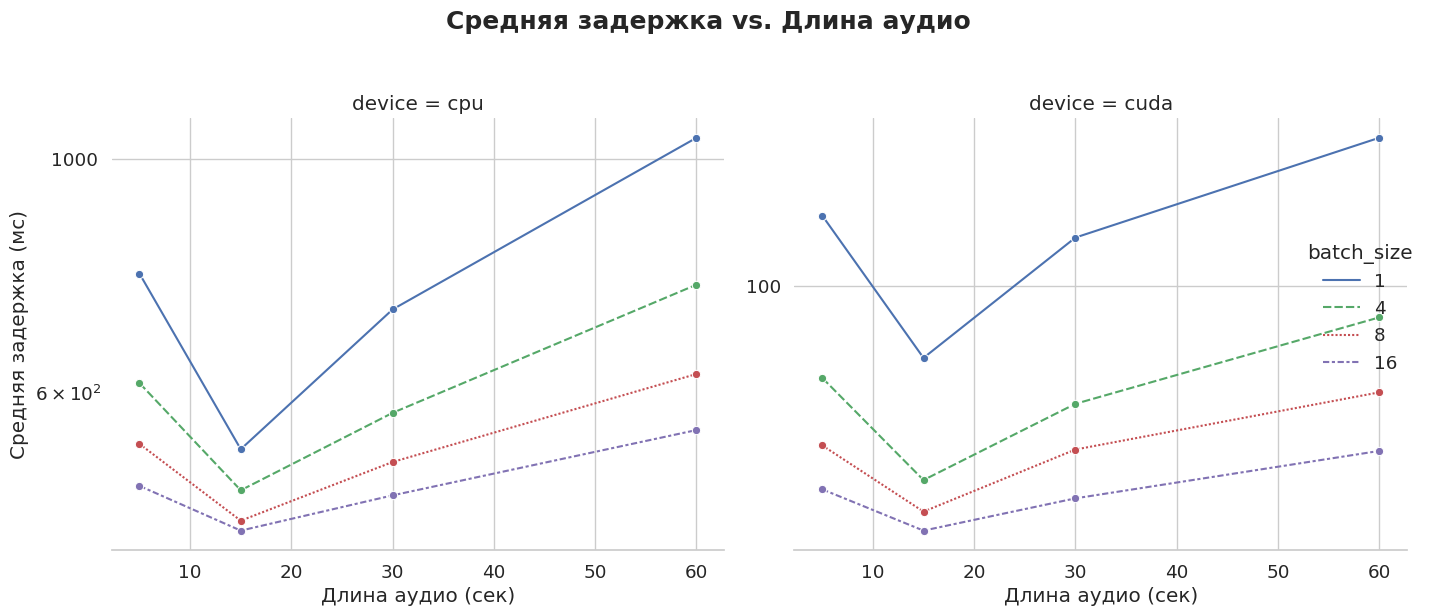

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

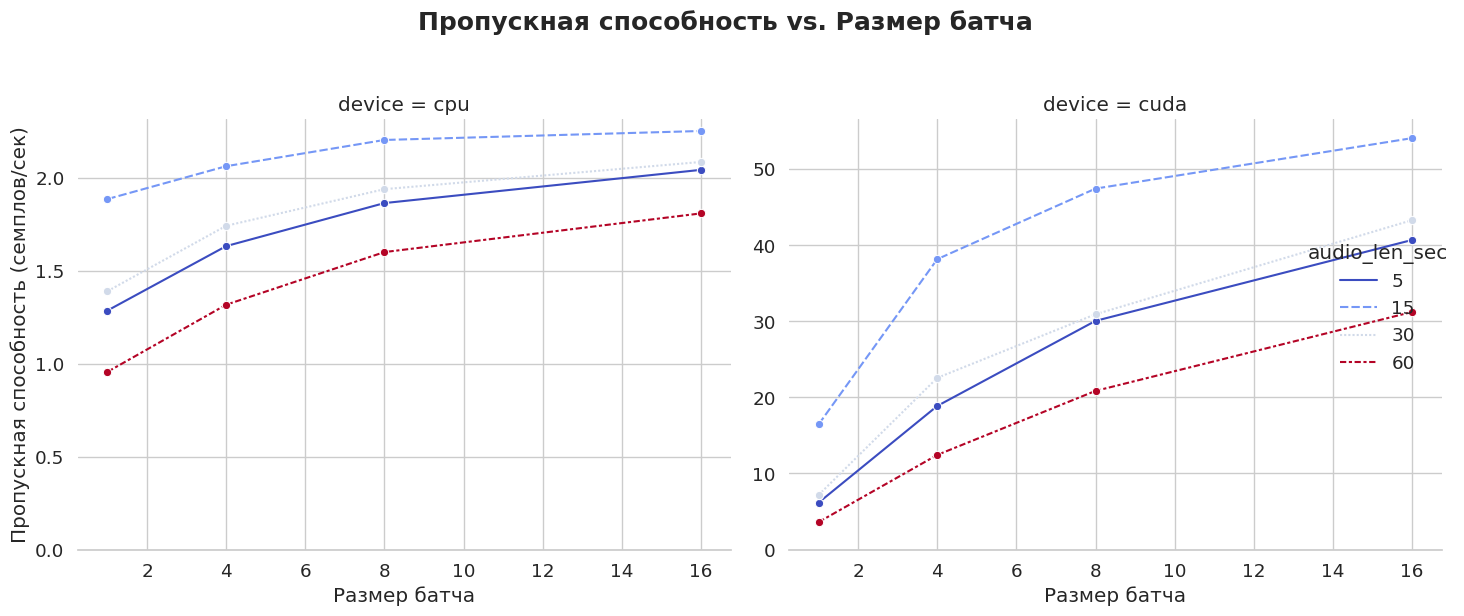

/tmp/ipykernel_79/1772496843.py:57: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.relplot(
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:11

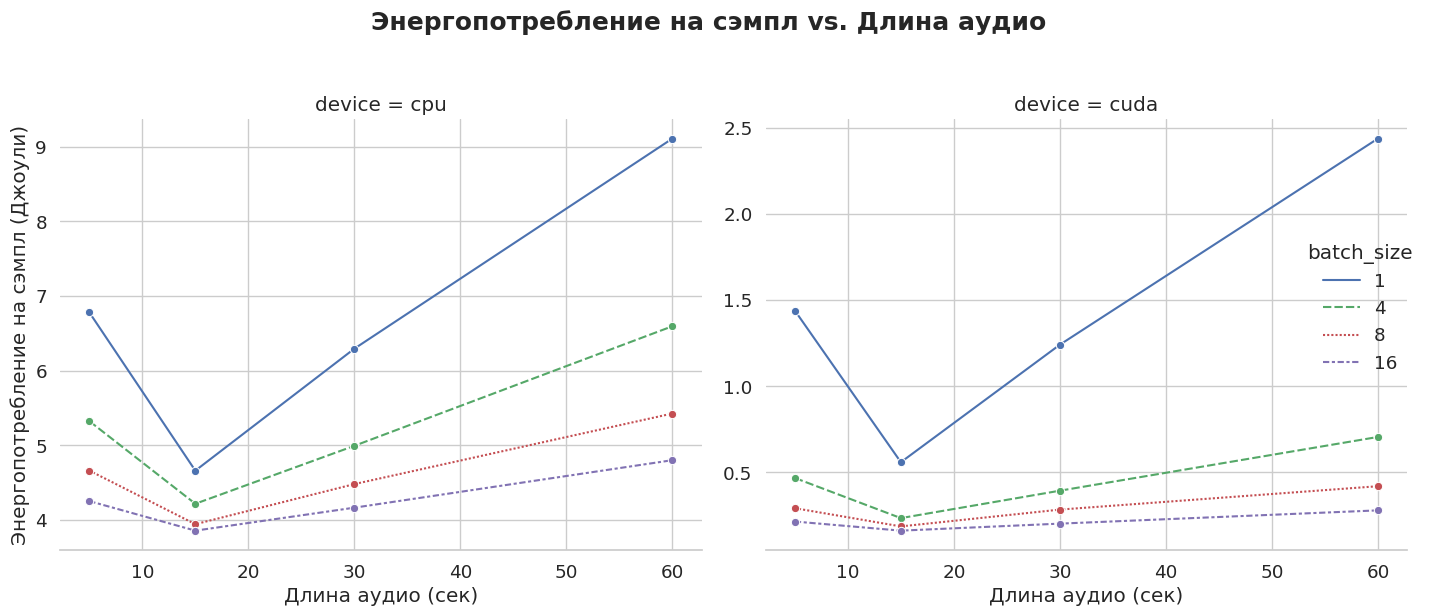

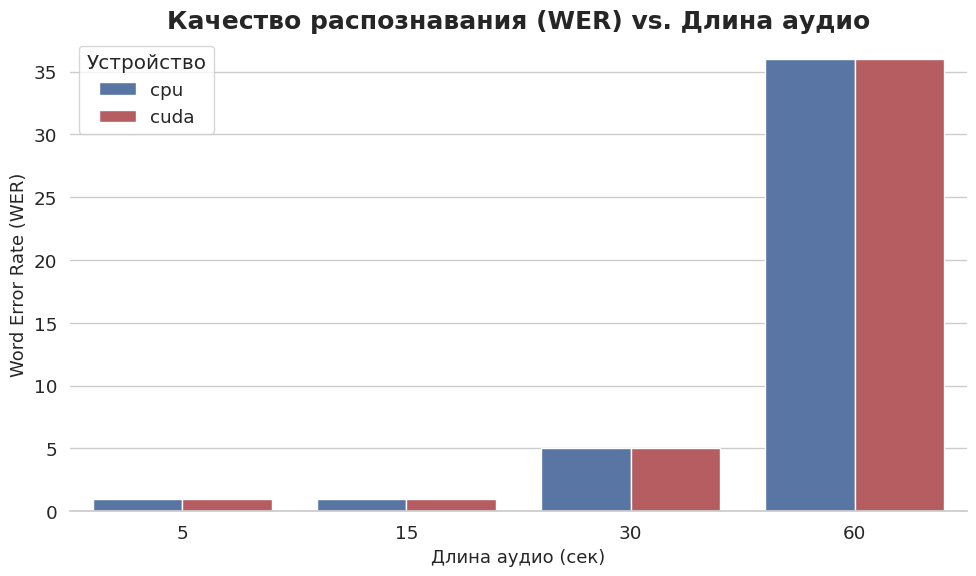

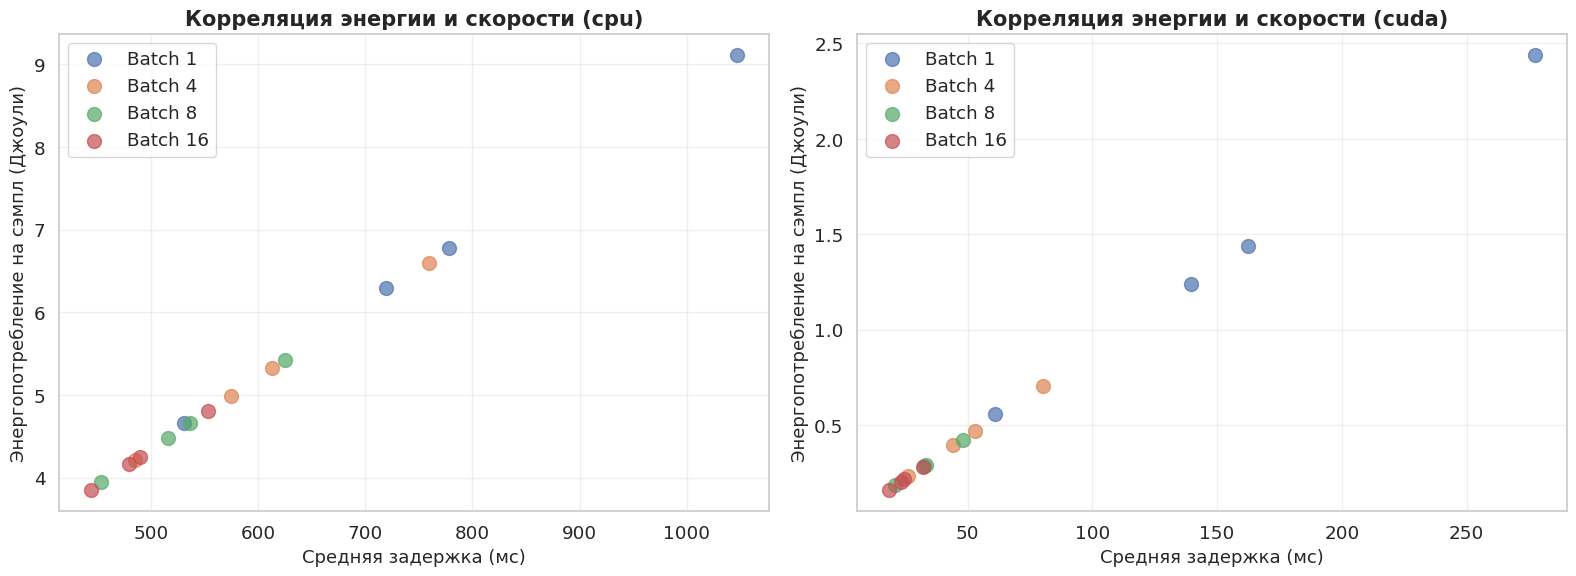


--- Корреляционный анализ энергии и скорости ---
cpu: корреляция задержки и энергии на сэмпл = 0.9999
cuda: корреляция задержки и энергии на сэмпл = 0.9999


In [62]:
analysis_and_visualization(results_df)

In [63]:
results = profiler.profile_model("openai/whisper-tiny", prepared_data)

ПРОФИЛИРОВАНИЕ МОДЕЛИ: openai/whisper-tiny
Время запуска: 2025-11-14 09:49:33

--- Настройка ---
Модель: openai/whisper-tiny
Длины аудио (сек): [5, 15, 30, 60]
Устройство: cuda

--- Загрузка модели ---
Модель загружена

--- Профилирование с аудио длительностью 30 секунд ---
Chrome trace сохранен: profiling_logs/whisper-tiny_20251114_094933_trace.json

=== Top 10 операций по CPU времени ===
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------

/tmp/ipykernel_79/1021075503.py:117: FutureWarning: `cuda_time` is deprecated, please use `device_time` instead.
  cuda_top = sorted(key_averages, key=lambda x: x.self_cuda_time_total if hasattr(x, 'self_cuda_time_total') else x.cuda_time if hasattr(x, 'cuda_time') else 0, reverse=True)[:10]
/tmp/ipykernel_79/1021075503.py:136: FutureWarning: `cuda_time` is deprecated, please use `device_time` instead.
  "cuda_time_total_ms": (op.self_cuda_time_total if hasattr(op, 'self_cuda_time_total') else op.cuda_time if hasattr(op, 'cuda_time') else 0) / 1000,


In [9]:
results_df = run_experiment("openai/whisper-medium")


--- Начало эксперимента ---
Обнаружен GPU: Tesla P100-PCIE-16GB

--- Загрузка модели: openai/whisper-medium ---
Модель и процессор загружены.

--- Тестирование на устройстве: CPU ---


Длина аудио (cpu):   0%|          | 0/4 [00:00<?, ?it/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
Using custom `forced_decoder_ids` from the (generation) config. This is deprecated in favor of the `task` and `language` flags/config options.
Transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English. This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`. See https://github.com/huggingface/transformers/pull/28687 for more details.


  Тест: audio_len=5s, batch_size=1, device=cpu


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
[codecarbon WARNING @ 10:04:26] Multiple instances of codecarbon are allowed to run at the same time.


  Тест: audio_len=5s, batch_size=4, device=cpu
  Тест: audio_len=5s, batch_size=8, device=cpu
  Тест: audio_len=5s, batch_size=16, device=cpu
  Тест: audio_len=15s, batch_size=1, device=cpu
  Тест: audio_len=15s, batch_size=4, device=cpu
  Тест: audio_len=15s, batch_size=8, device=cpu
  Тест: audio_len=15s, batch_size=16, device=cpu
  Тест: audio_len=30s, batch_size=1, device=cpu
  Тест: audio_len=30s, batch_size=4, device=cpu
  Тест: audio_len=30s, batch_size=8, device=cpu
  Тест: audio_len=30s, batch_size=16, device=cpu
  Тест: audio_len=60s, batch_size=1, device=cpu
  Тест: audio_len=60s, batch_size=4, device=cpu
  Тест: audio_len=60s, batch_size=8, device=cpu
  Тест: audio_len=60s, batch_size=16, device=cpu

--- Тестирование на устройстве: CUDA ---


Длина аудио (cuda):   0%|          | 0/4 [00:00<?, ?it/s]

  Тест: audio_len=5s, batch_size=1, device=cuda
  Тест: audio_len=5s, batch_size=4, device=cuda
  Тест: audio_len=5s, batch_size=8, device=cuda
  Тест: audio_len=5s, batch_size=16, device=cuda
  Тест: audio_len=15s, batch_size=1, device=cuda
  Тест: audio_len=15s, batch_size=4, device=cuda
  Тест: audio_len=15s, batch_size=8, device=cuda
  Тест: audio_len=15s, batch_size=16, device=cuda
  Тест: audio_len=30s, batch_size=1, device=cuda
  Тест: audio_len=30s, batch_size=4, device=cuda
  Тест: audio_len=30s, batch_size=8, device=cuda
  Тест: audio_len=30s, batch_size=16, device=cuda
  Тест: audio_len=60s, batch_size=1, device=cuda
  Тест: audio_len=60s, batch_size=4, device=cuda
  Тест: audio_len=60s, batch_size=8, device=cuda
  Тест: audio_len=60s, batch_size=16, device=cuda

Эксперимент завершен!
Всего результатов: 32



--- 5. Улучшенный анализ и визуализация ---


,model_id,device,audio_len_sec,batch_size,avg_latency_ms,wer,energy_joules,encoder_gflops,decoder_step_gflops
0,openai/whisper-medium,cpu,5,1,14589.407444,1.0,126.551942,917.48352,0.604381
1,openai/whisper-medium,cpu,5,4,13340.217292,1.0,462.702907,917.48352,0.604381
2,openai/whisper-medium,cpu,5,8,12438.851207,1.0,862.804171,917.48352,0.604381
3,openai/whisper-medium,cpu,5,16,13913.712516,1.0,1930.057941,917.48352,0.604381
4,openai/whisper-medium,cpu,15,1,12219.832420,1.0,106.002592,917.48352,0.604381
5,openai/whisper-medium,cpu,15,4,11935.356379,1.0,413.948092,917.48352,0.604381
6,openai/whisper-medium,cpu,15,8,11957.885772,1.0,829.387449,917.48352,0.604381
7,openai/whisper-medium,cpu,15,16,14200.403273,1.0,1969.877862,917.48352,0.604381
8,openai/whisper-medium,cpu,30,1,12934.545994,4.0,112.198446,917.48352,0.604381
9,openai/whisper-medium,cpu,30,4,12336.620390,4.0,427.871861,917.48352,0.604381


/tmp/ipykernel_2332/1772496843.py:13: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.relplot(
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:

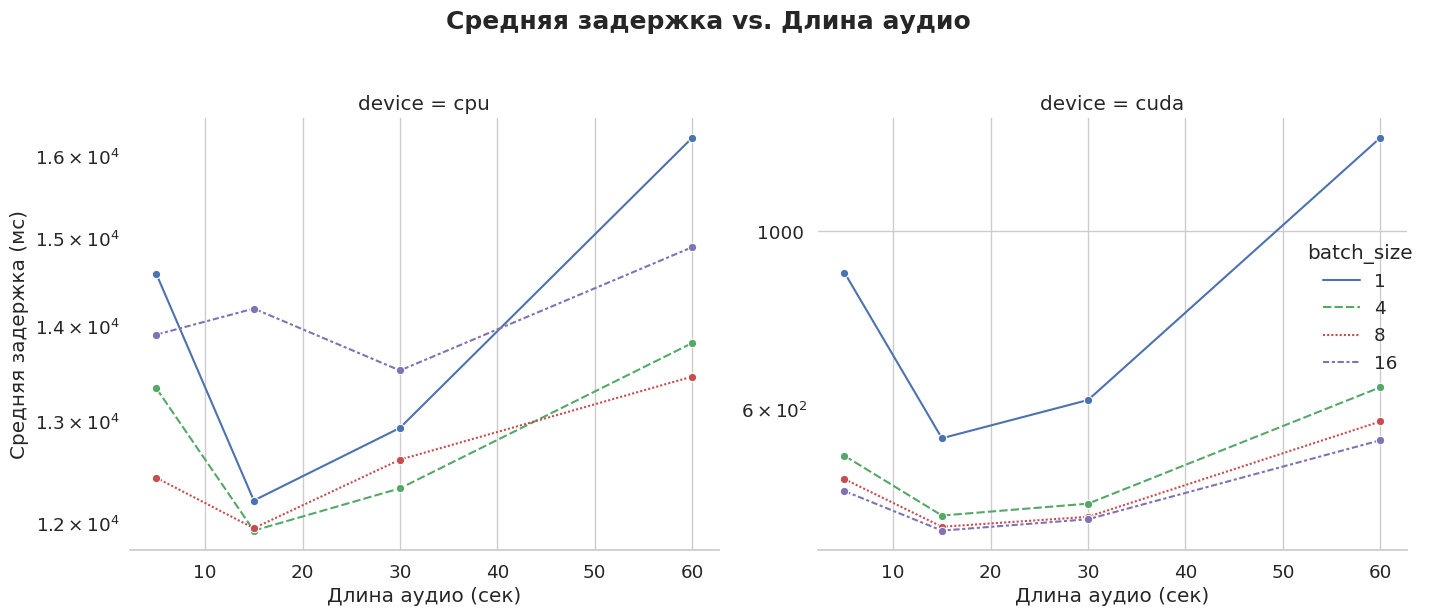

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

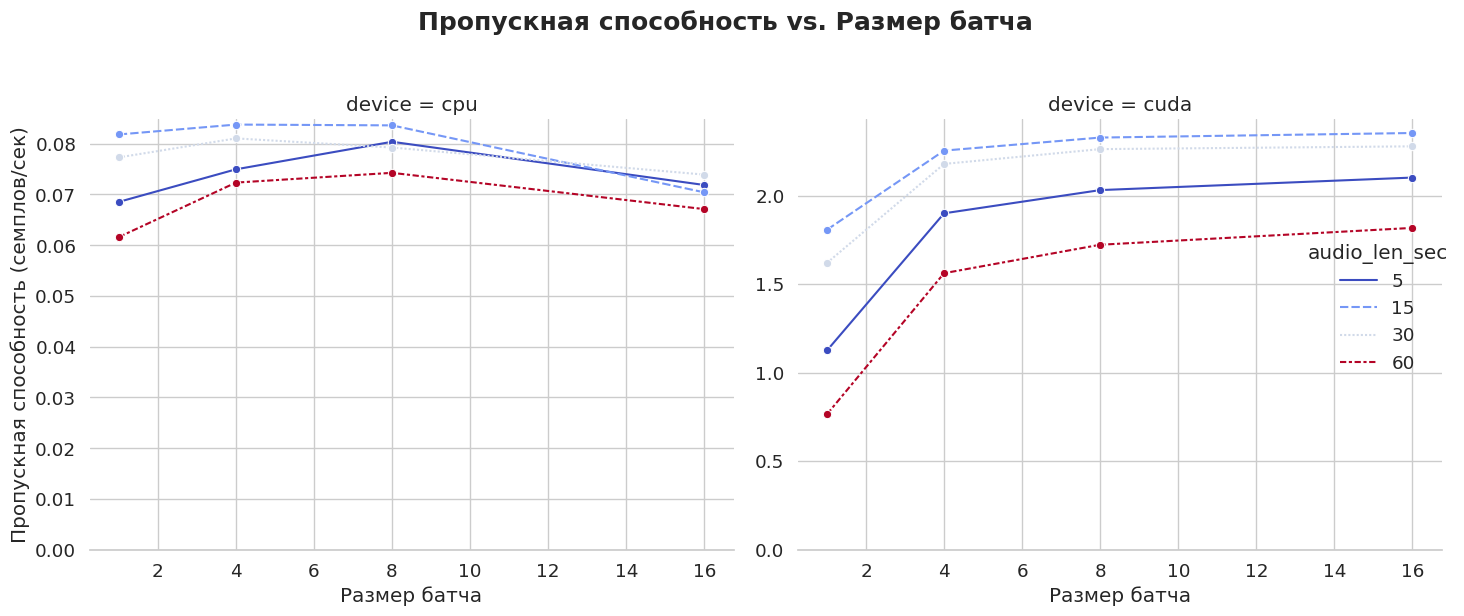

/tmp/ipykernel_2332/1772496843.py:57: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.relplot(
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:

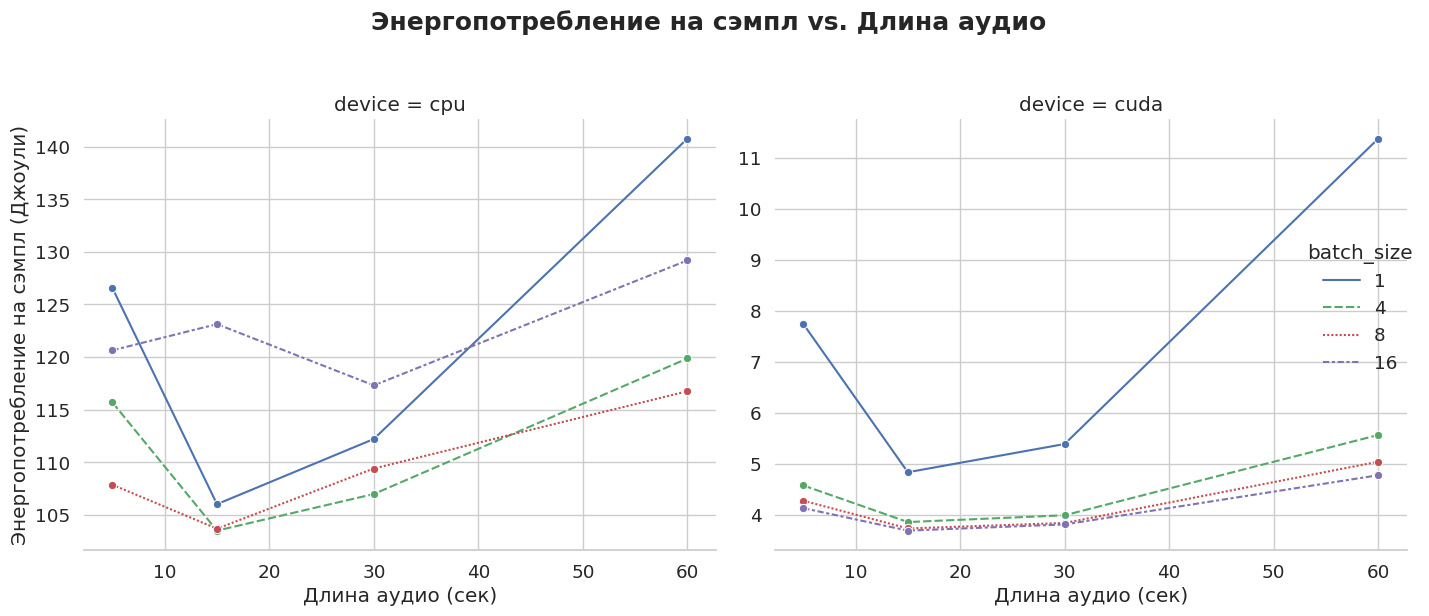

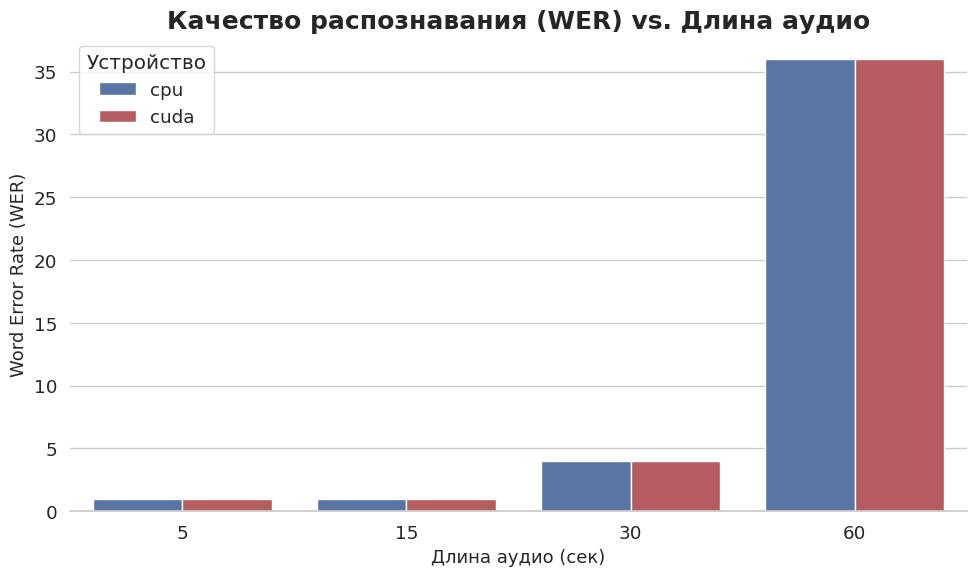

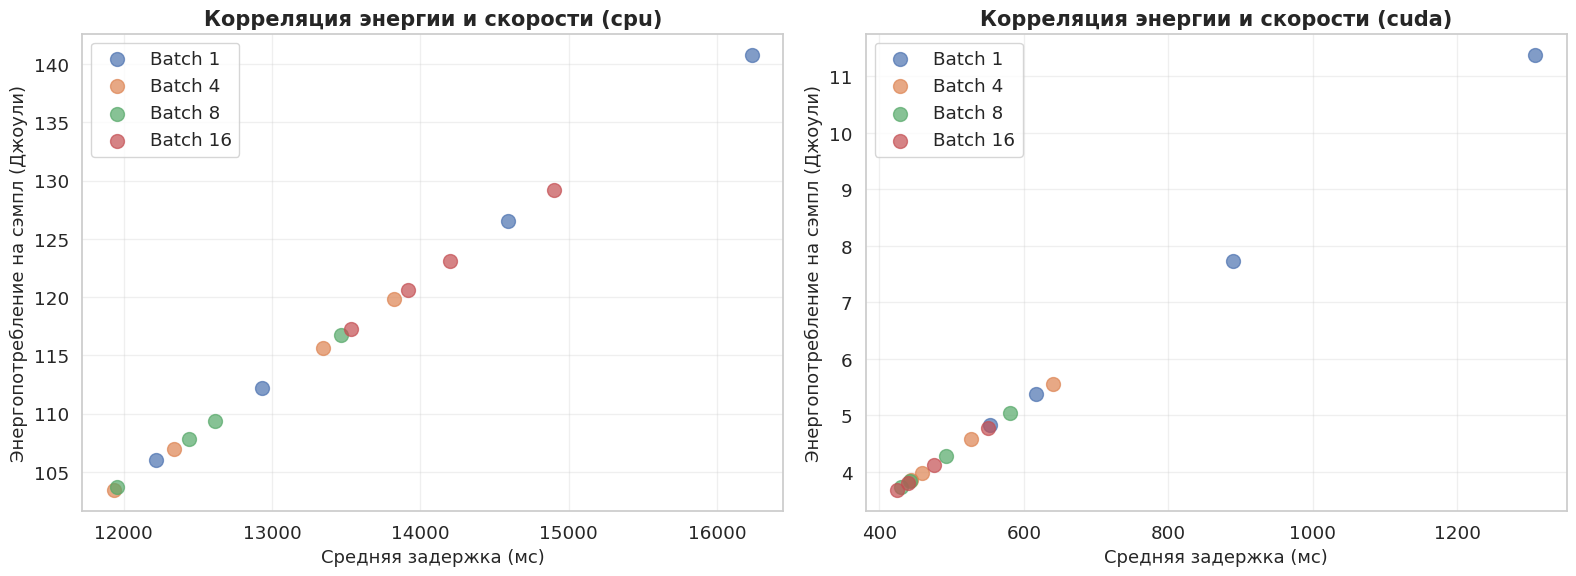


--- Корреляционный анализ энергии и скорости ---
cpu: корреляция задержки и энергии на сэмпл = 1.0000
cuda: корреляция задержки и энергии на сэмпл = 1.0000


In [10]:
analysis_and_visualization(results_df)

In [11]:
results = profiler.profile_model("openai/whisper-medium", prepared_data)

ПРОФИЛИРОВАНИЕ МОДЕЛИ: openai/whisper-medium
Время запуска: 2025-11-14 11:00:41

--- Настройка ---
Модель: openai/whisper-medium
Длины аудио (сек): [5, 15, 30, 60]
Устройство: cuda

--- Загрузка модели ---
Модель загружена

--- Профилирование с аудио длительностью 30 секунд ---
Chrome trace сохранен: profiling_logs/whisper-medium_20251114_110041_trace.json

=== Top 10 операций по CPU времени ===
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------

/tmp/ipykernel_2332/1021075503.py:117: FutureWarning: `cuda_time` is deprecated, please use `device_time` instead.
  cuda_top = sorted(key_averages, key=lambda x: x.self_cuda_time_total if hasattr(x, 'self_cuda_time_total') else x.cuda_time if hasattr(x, 'cuda_time') else 0, reverse=True)[:10]
/tmp/ipykernel_2332/1021075503.py:136: FutureWarning: `cuda_time` is deprecated, please use `device_time` instead.
  "cuda_time_total_ms": (op.self_cuda_time_total if hasattr(op, 'self_cuda_time_total') else op.cuda_time if hasattr(op, 'cuda_time') else 0) / 1000,


In [12]:
results_df = run_experiment("openai/whisper-base")


--- Начало эксперимента ---
Обнаружен GPU: Tesla P100-PCIE-16GB

--- Загрузка модели: openai/whisper-base ---


preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/290M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

Модель и процессор загружены.

--- Тестирование на устройстве: CPU ---


Длина аудио (cpu):   0%|          | 0/4 [00:00<?, ?it/s]

  Тест: audio_len=5s, batch_size=1, device=cpu
  Тест: audio_len=5s, batch_size=4, device=cpu
  Тест: audio_len=5s, batch_size=8, device=cpu
  Тест: audio_len=5s, batch_size=16, device=cpu
  Тест: audio_len=15s, batch_size=1, device=cpu
  Тест: audio_len=15s, batch_size=4, device=cpu
  Тест: audio_len=15s, batch_size=8, device=cpu
  Тест: audio_len=15s, batch_size=16, device=cpu
  Тест: audio_len=30s, batch_size=1, device=cpu
  Тест: audio_len=30s, batch_size=4, device=cpu
  Тест: audio_len=30s, batch_size=8, device=cpu
  Тест: audio_len=30s, batch_size=16, device=cpu
  Тест: audio_len=60s, batch_size=1, device=cpu
  Тест: audio_len=60s, batch_size=4, device=cpu
  Тест: audio_len=60s, batch_size=8, device=cpu
  Тест: audio_len=60s, batch_size=16, device=cpu

--- Тестирование на устройстве: CUDA ---


Длина аудио (cuda):   0%|          | 0/4 [00:00<?, ?it/s]

  Тест: audio_len=5s, batch_size=1, device=cuda
  Тест: audio_len=5s, batch_size=4, device=cuda
  Тест: audio_len=5s, batch_size=8, device=cuda
  Тест: audio_len=5s, batch_size=16, device=cuda
  Тест: audio_len=15s, batch_size=1, device=cuda
  Тест: audio_len=15s, batch_size=4, device=cuda
  Тест: audio_len=15s, batch_size=8, device=cuda
  Тест: audio_len=15s, batch_size=16, device=cuda
  Тест: audio_len=30s, batch_size=1, device=cuda
  Тест: audio_len=30s, batch_size=4, device=cuda
  Тест: audio_len=30s, batch_size=8, device=cuda
  Тест: audio_len=30s, batch_size=16, device=cuda
  Тест: audio_len=60s, batch_size=1, device=cuda
  Тест: audio_len=60s, batch_size=4, device=cuda
  Тест: audio_len=60s, batch_size=8, device=cuda
  Тест: audio_len=60s, batch_size=16, device=cuda

Эксперимент завершен!
Всего результатов: 32



--- 5. Улучшенный анализ и визуализация ---


,model_id,device,audio_len_sec,batch_size,avg_latency_ms,wer,energy_joules,encoder_gflops,decoder_step_gflops
0,openai/whisper-base,cpu,5,1,1579.232454,0.96875,13.746498,59.799552,0.037802
1,openai/whisper-base,cpu,5,4,1261.087716,0.96875,43.781228,59.799552,0.037802
2,openai/whisper-base,cpu,5,8,1182.746798,0.96875,82.086023,59.799552,0.037802
3,openai/whisper-base,cpu,5,16,1153.670073,0.96875,160.105160,59.799552,0.037802
4,openai/whisper-base,cpu,15,1,1143.915176,1.00000,9.952956,59.799552,0.037802
5,openai/whisper-base,cpu,15,4,1050.826490,1.00000,36.483146,59.799552,0.037802
6,openai/whisper-base,cpu,15,8,1057.156295,1.00000,73.371922,59.799552,0.037802
7,openai/whisper-base,cpu,15,16,1040.113524,1.00000,144.319916,59.799552,0.037802
8,openai/whisper-base,cpu,30,1,1248.333931,4.00000,10.867298,59.799552,0.037802
9,openai/whisper-base,cpu,30,4,1108.292162,4.00000,38.475474,59.799552,0.037802


/tmp/ipykernel_2332/1772496843.py:13: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.relplot(
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:

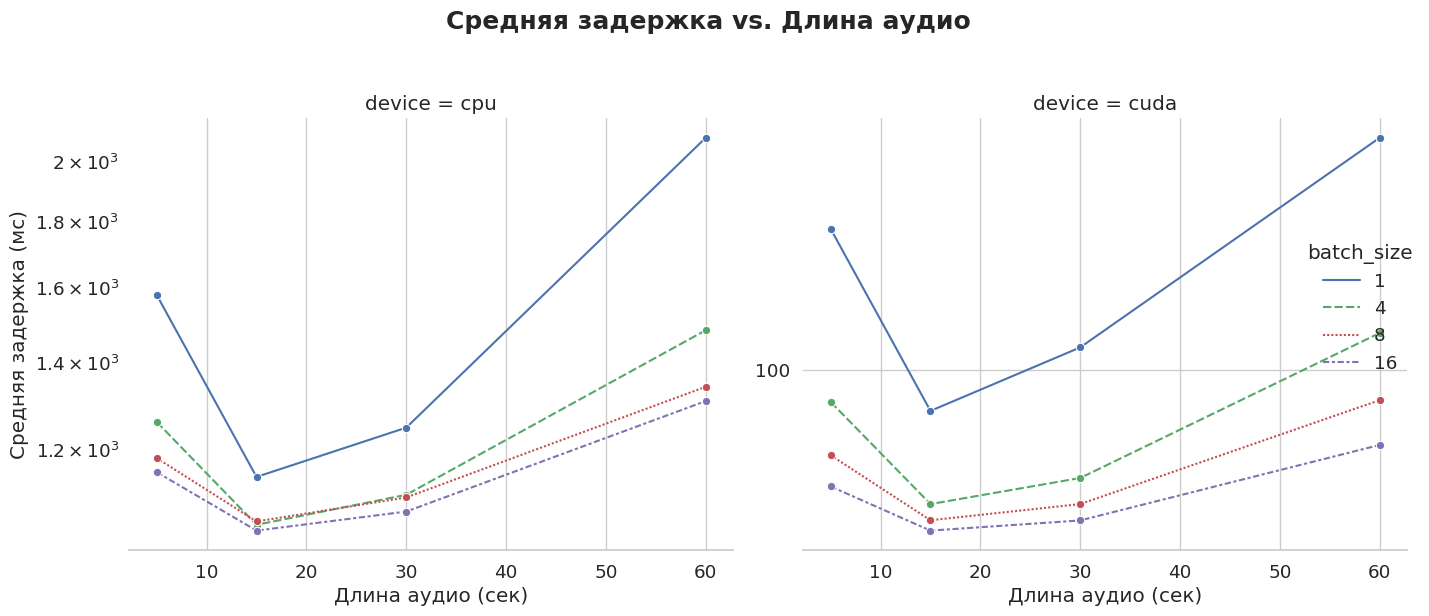

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

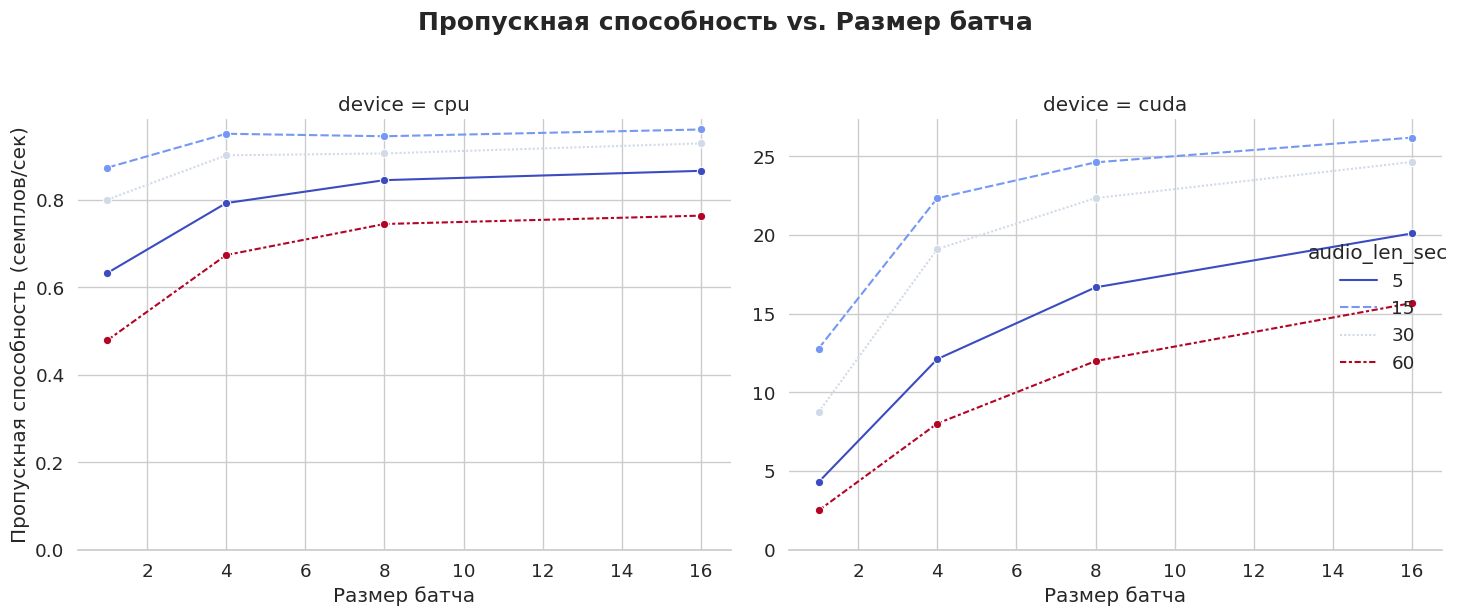

/tmp/ipykernel_2332/1772496843.py:57: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.relplot(
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:

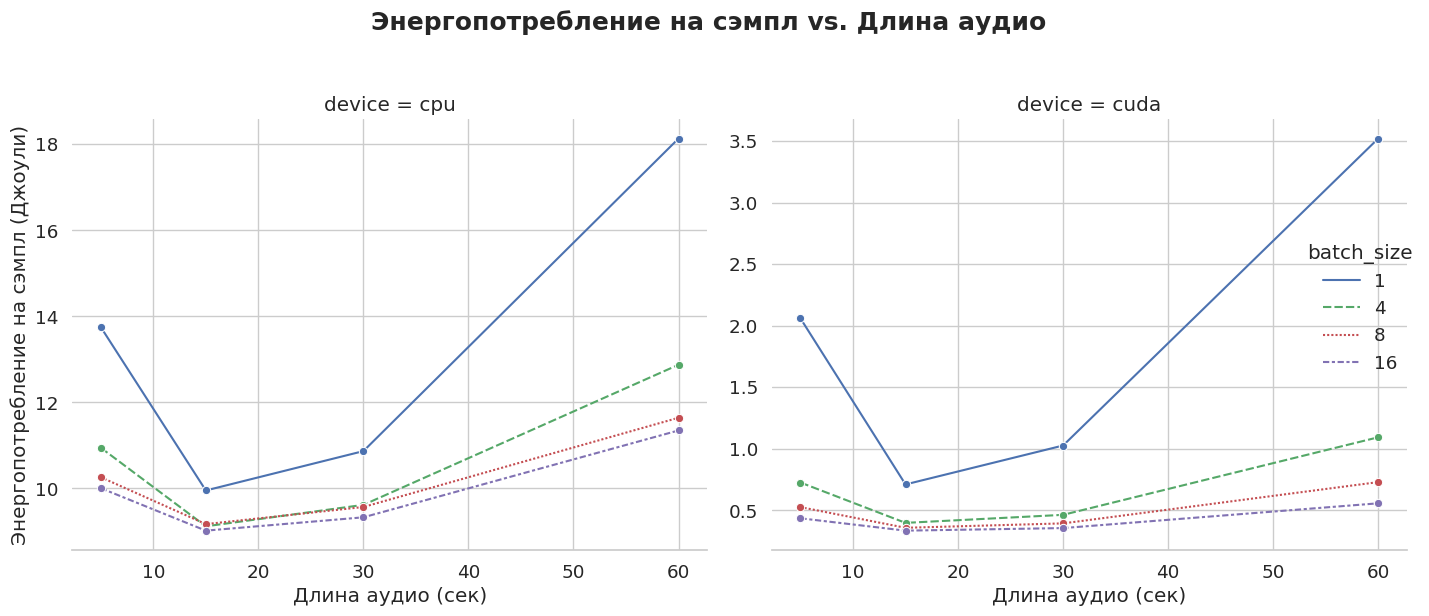

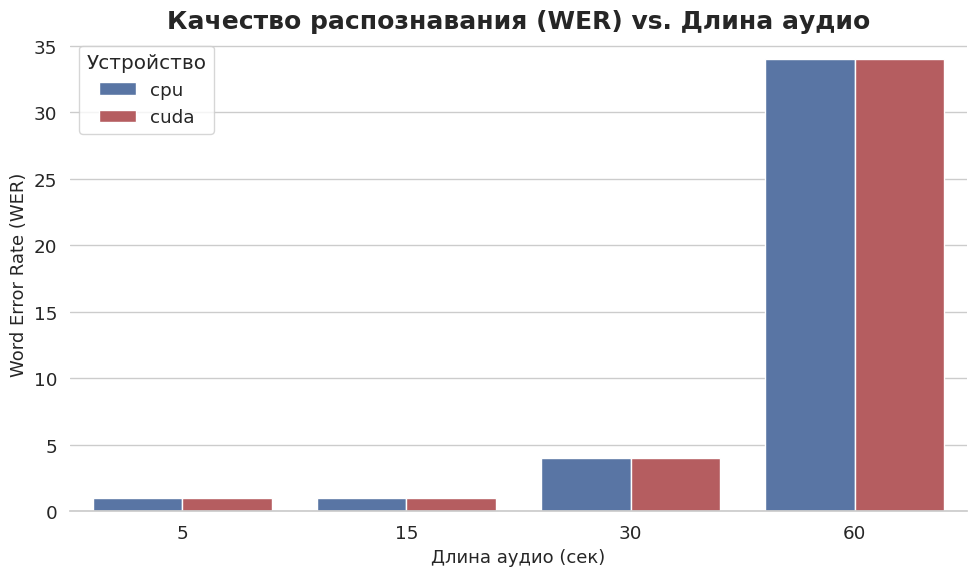

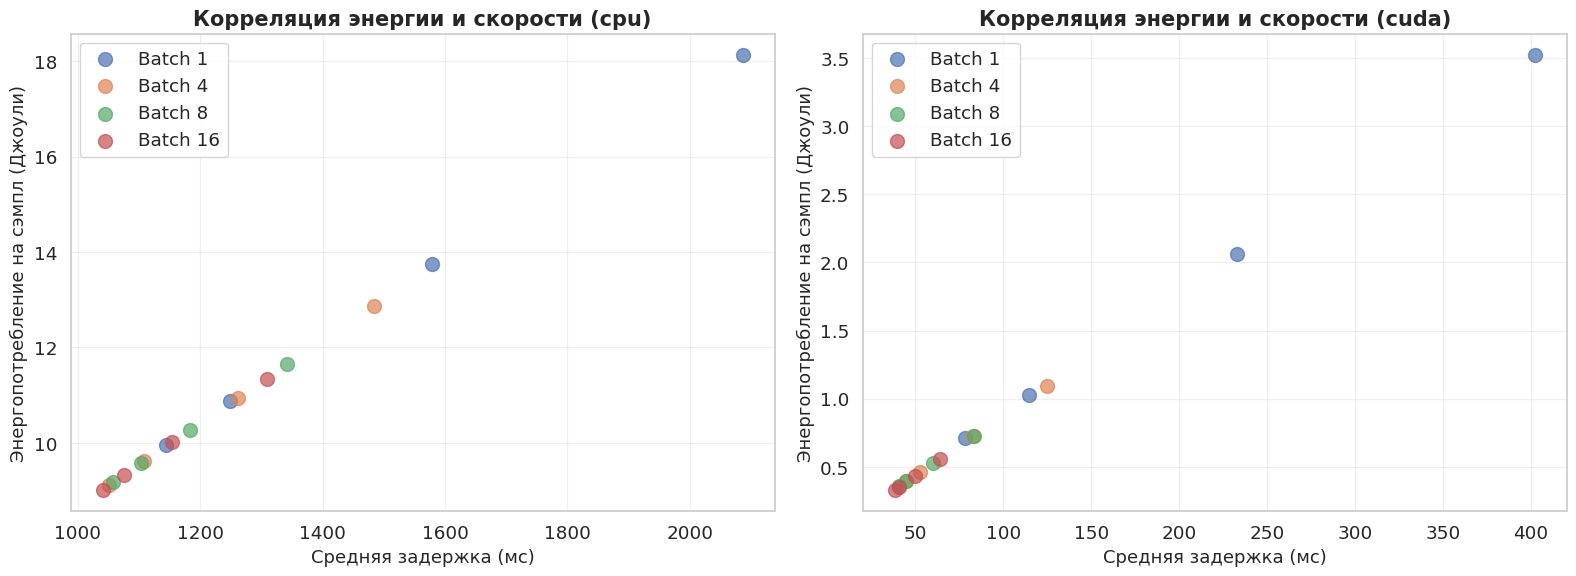


--- Корреляционный анализ энергии и скорости ---
cpu: корреляция задержки и энергии на сэмпл = 1.0000
cuda: корреляция задержки и энергии на сэмпл = 0.9999


In [13]:
analysis_and_visualization(results_df)

In [14]:
results = profiler.profile_model("openai/whisper-base", prepared_data)

ПРОФИЛИРОВАНИЕ МОДЕЛИ: openai/whisper-base
Время запуска: 2025-11-14 11:09:20

--- Настройка ---
Модель: openai/whisper-base
Длины аудио (сек): [5, 15, 30, 60]
Устройство: cuda

--- Загрузка модели ---
Модель загружена

--- Профилирование с аудио длительностью 30 секунд ---
Chrome trace сохранен: profiling_logs/whisper-base_20251114_110920_trace.json

=== Top 10 операций по CPU времени ===
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------

/tmp/ipykernel_2332/1021075503.py:117: FutureWarning: `cuda_time` is deprecated, please use `device_time` instead.
  cuda_top = sorted(key_averages, key=lambda x: x.self_cuda_time_total if hasattr(x, 'self_cuda_time_total') else x.cuda_time if hasattr(x, 'cuda_time') else 0, reverse=True)[:10]
/tmp/ipykernel_2332/1021075503.py:136: FutureWarning: `cuda_time` is deprecated, please use `device_time` instead.
  "cuda_time_total_ms": (op.self_cuda_time_total if hasattr(op, 'self_cuda_time_total') else op.cuda_time if hasattr(op, 'cuda_time') else 0) / 1000,


In [15]:
results_df = run_experiment("openai/whisper-small")


--- Начало эксперимента ---
Обнаружен GPU: Tesla P100-PCIE-16GB

--- Загрузка модели: openai/whisper-small ---


preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

Модель и процессор загружены.

--- Тестирование на устройстве: CPU ---


Длина аудио (cpu):   0%|          | 0/4 [00:00<?, ?it/s]

  Тест: audio_len=5s, batch_size=1, device=cpu
  Тест: audio_len=5s, batch_size=4, device=cpu
  Тест: audio_len=5s, batch_size=8, device=cpu
  Тест: audio_len=5s, batch_size=16, device=cpu
  Тест: audio_len=15s, batch_size=1, device=cpu
  Тест: audio_len=15s, batch_size=4, device=cpu
  Тест: audio_len=15s, batch_size=8, device=cpu
  Тест: audio_len=15s, batch_size=16, device=cpu
  Тест: audio_len=30s, batch_size=1, device=cpu
  Тест: audio_len=30s, batch_size=4, device=cpu
  Тест: audio_len=30s, batch_size=8, device=cpu
  Тест: audio_len=30s, batch_size=16, device=cpu
  Тест: audio_len=60s, batch_size=1, device=cpu
  Тест: audio_len=60s, batch_size=4, device=cpu
  Тест: audio_len=60s, batch_size=8, device=cpu
  Тест: audio_len=60s, batch_size=16, device=cpu

--- Тестирование на устройстве: CUDA ---


Длина аудио (cuda):   0%|          | 0/4 [00:00<?, ?it/s]

  Тест: audio_len=5s, batch_size=1, device=cuda
  Тест: audio_len=5s, batch_size=4, device=cuda
  Тест: audio_len=5s, batch_size=8, device=cuda
  Тест: audio_len=5s, batch_size=16, device=cuda
  Тест: audio_len=15s, batch_size=1, device=cuda
  Тест: audio_len=15s, batch_size=4, device=cuda
  Тест: audio_len=15s, batch_size=8, device=cuda
  Тест: audio_len=15s, batch_size=16, device=cuda
  Тест: audio_len=30s, batch_size=1, device=cuda
  Тест: audio_len=30s, batch_size=4, device=cuda
  Тест: audio_len=30s, batch_size=8, device=cuda
  Тест: audio_len=30s, batch_size=16, device=cuda
  Тест: audio_len=60s, batch_size=1, device=cuda
  Тест: audio_len=60s, batch_size=4, device=cuda
  Тест: audio_len=60s, batch_size=8, device=cuda
  Тест: audio_len=60s, batch_size=16, device=cuda

Эксперимент завершен!
Всего результатов: 32



--- 5. Улучшенный анализ и визуализация ---


,model_id,device,audio_len_sec,batch_size,avg_latency_ms,wer,energy_joules,encoder_gflops,decoder_step_gflops
0,openai/whisper-small,cpu,5,1,4810.915470,0.96875,41.776324,261.448704,0.170023
1,openai/whisper-small,cpu,5,4,4266.506255,0.96875,147.997383,261.448704,0.170023
2,openai/whisper-small,cpu,5,8,4053.983867,0.96875,281.217251,261.448704,0.170023
3,openai/whisper-small,cpu,5,16,3881.052494,0.96875,538.398283,261.448704,0.170023
4,openai/whisper-small,cpu,15,1,4144.970655,1.00000,35.977085,261.448704,0.170023
5,openai/whisper-small,cpu,15,4,3864.460468,1.00000,134.051315,261.448704,0.170023
6,openai/whisper-small,cpu,15,8,3847.582400,1.00000,266.900019,261.448704,0.170023
7,openai/whisper-small,cpu,15,16,3742.042378,1.00000,519.125038,261.448704,0.170023
8,openai/whisper-small,cpu,30,1,4440.391779,8.00000,38.543774,261.448704,0.170023
9,openai/whisper-small,cpu,30,4,4080.390215,8.00000,141.539862,261.448704,0.170023


/tmp/ipykernel_2332/1772496843.py:13: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.relplot(
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:

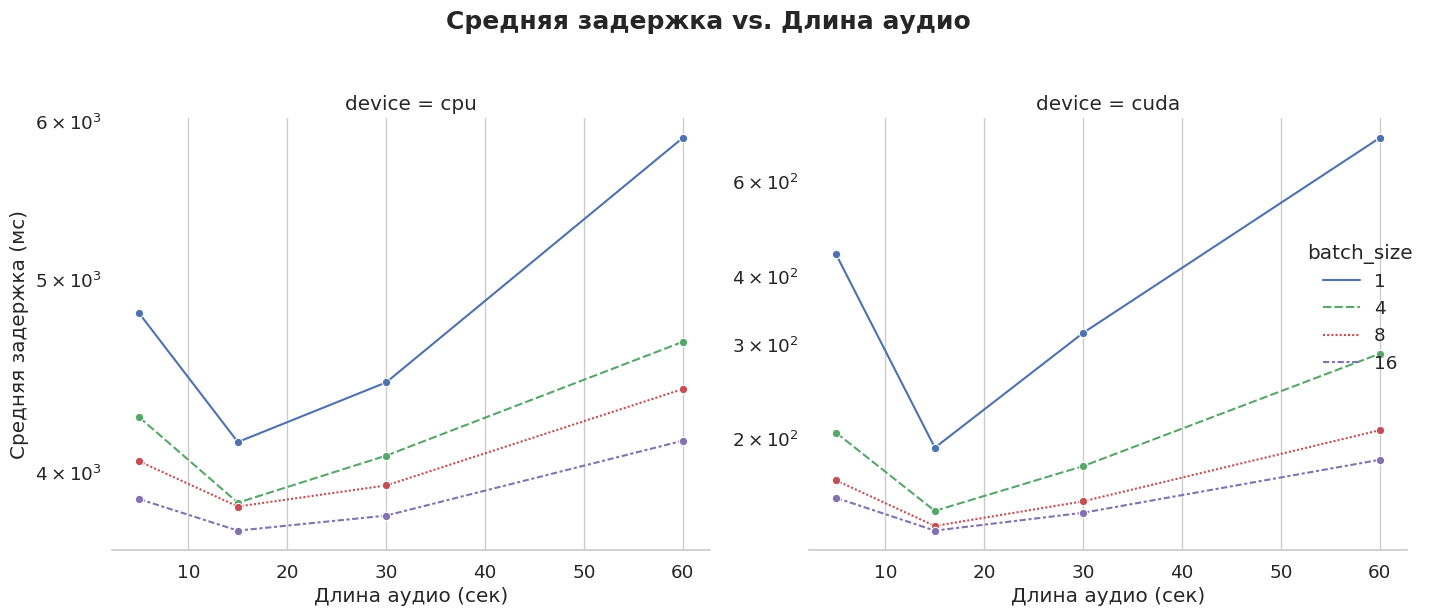

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

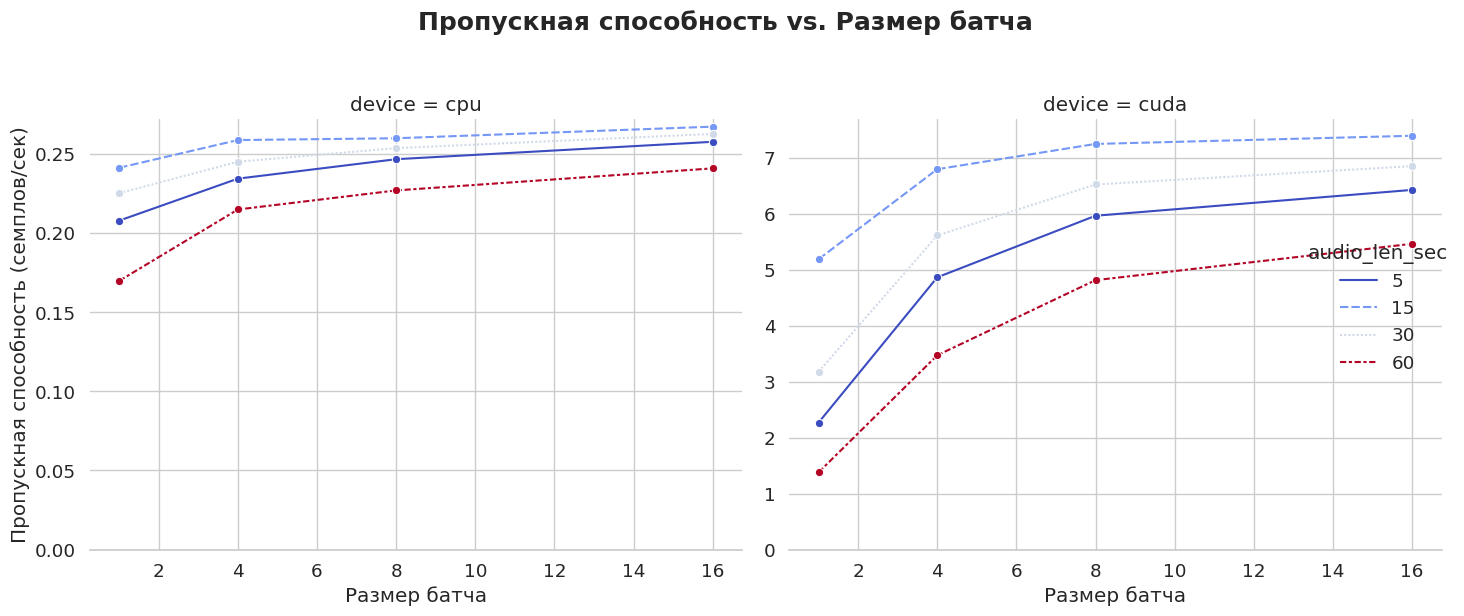

/tmp/ipykernel_2332/1772496843.py:57: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.relplot(
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:

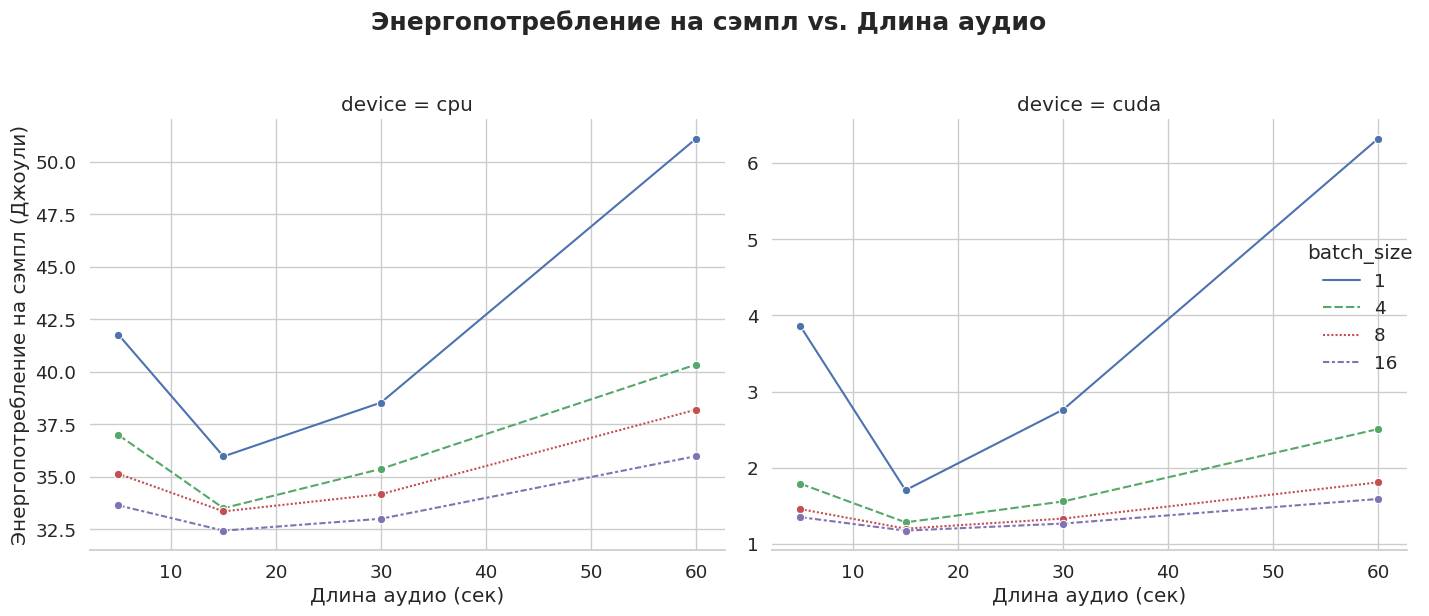

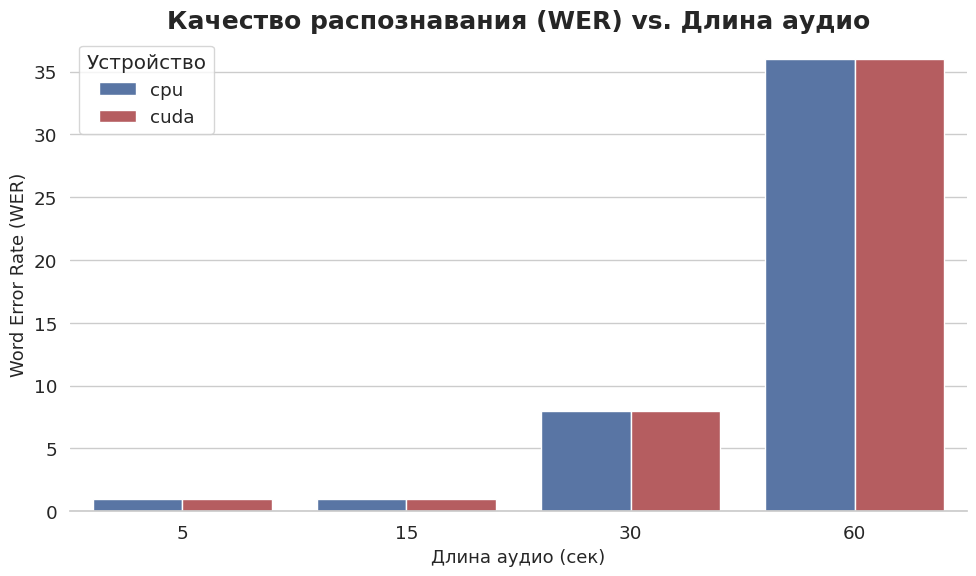

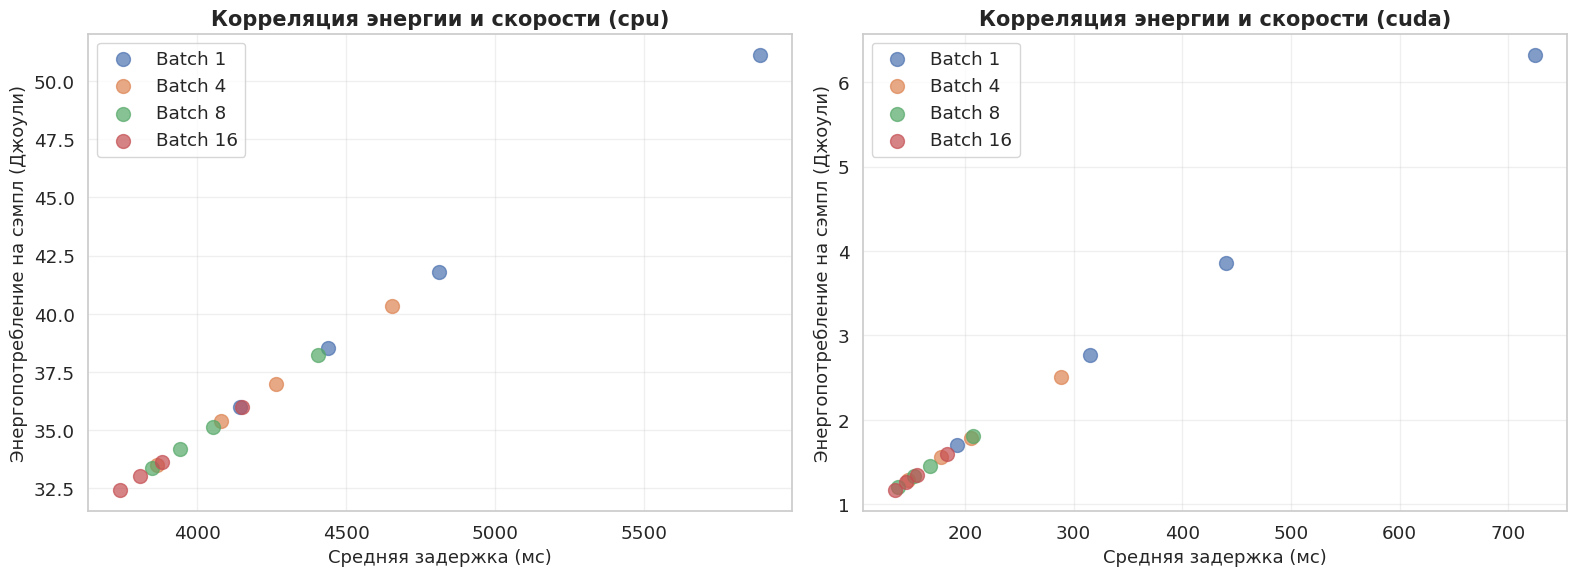


--- Корреляционный анализ энергии и скорости ---
cpu: корреляция задержки и энергии на сэмпл = 1.0000
cuda: корреляция задержки и энергии на сэмпл = 1.0000


In [16]:
analysis_and_visualization(results_df)

In [17]:
results = profiler.profile_model("openai/whisper-small", prepared_data)

ПРОФИЛИРОВАНИЕ МОДЕЛИ: openai/whisper-small
Время запуска: 2025-11-14 11:30:42

--- Настройка ---
Модель: openai/whisper-small
Длины аудио (сек): [5, 15, 30, 60]
Устройство: cuda

--- Загрузка модели ---
Модель загружена

--- Профилирование с аудио длительностью 30 секунд ---
Chrome trace сохранен: profiling_logs/whisper-small_20251114_113042_trace.json

=== Top 10 операций по CPU времени ===
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total MFLOPs  
-------------------------------------------------------  ---------

/tmp/ipykernel_2332/1021075503.py:117: FutureWarning: `cuda_time` is deprecated, please use `device_time` instead.
  cuda_top = sorted(key_averages, key=lambda x: x.self_cuda_time_total if hasattr(x, 'self_cuda_time_total') else x.cuda_time if hasattr(x, 'cuda_time') else 0, reverse=True)[:10]
/tmp/ipykernel_2332/1021075503.py:136: FutureWarning: `cuda_time` is deprecated, please use `device_time` instead.
  "cuda_time_total_ms": (op.self_cuda_time_total if hasattr(op, 'self_cuda_time_total') else op.cuda_time if hasattr(op, 'cuda_time') else 0) / 1000,


In [9]:
results_df = run_experiment("facebook/wav2vec2-base-960h")


--- Начало эксперимента ---
Обнаружен GPU: Tesla P100-PCIE-16GB

--- Загрузка модели: facebook/wav2vec2-base-960h ---


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Модель и процессор загружены.

--- Тестирование на устройстве: CPU ---


Длина аудио (cpu):   0%|          | 0/4 [00:00<?, ?it/s]

  Тест: audio_len=5s, batch_size=1, device=cpu


[codecarbon WARNING @ 12:23:42] Multiple instances of codecarbon are allowed to run at the same time.


  Тест: audio_len=5s, batch_size=4, device=cpu
  Тест: audio_len=5s, batch_size=8, device=cpu
  Тест: audio_len=5s, batch_size=16, device=cpu
  Тест: audio_len=15s, batch_size=1, device=cpu
  Тест: audio_len=15s, batch_size=4, device=cpu
  Тест: audio_len=15s, batch_size=8, device=cpu
  Тест: audio_len=15s, batch_size=16, device=cpu
  Тест: audio_len=30s, batch_size=1, device=cpu
  Тест: audio_len=30s, batch_size=4, device=cpu
  Тест: audio_len=30s, batch_size=8, device=cpu
  Тест: audio_len=30s, batch_size=16, device=cpu
  Тест: audio_len=60s, batch_size=1, device=cpu
  Тест: audio_len=60s, batch_size=4, device=cpu
  Тест: audio_len=60s, batch_size=8, device=cpu
  Тест: audio_len=60s, batch_size=16, device=cpu

--- Тестирование на устройстве: CUDA ---


Длина аудио (cuda):   0%|          | 0/4 [00:00<?, ?it/s]

  Тест: audio_len=5s, batch_size=1, device=cuda
  Тест: audio_len=5s, batch_size=4, device=cuda
  Тест: audio_len=5s, batch_size=8, device=cuda
  Тест: audio_len=5s, batch_size=16, device=cuda
  Тест: audio_len=15s, batch_size=1, device=cuda
  Тест: audio_len=15s, batch_size=4, device=cuda
  Тест: audio_len=15s, batch_size=8, device=cuda
  Тест: audio_len=15s, batch_size=16, device=cuda
  Тест: audio_len=30s, batch_size=1, device=cuda
  Тест: audio_len=30s, batch_size=4, device=cuda
  Тест: audio_len=30s, batch_size=8, device=cuda
  Тест: audio_len=30s, batch_size=16, device=cuda
  Тест: audio_len=60s, batch_size=1, device=cuda
  Тест: audio_len=60s, batch_size=4, device=cuda
  Тест: audio_len=60s, batch_size=8, device=cuda
  Тест: audio_len=60s, batch_size=16, device=cuda

Эксперимент завершен!
Всего результатов: 32



--- 5. Улучшенный анализ и визуализация ---


,model_id,device,audio_len_sec,batch_size,avg_latency_ms,wer,energy_joules,encoder_gflops,decoder_step_gflops,throughput_sps,energy_per_sample_joules
0,facebook/wav2vec2-base-960h,cpu,5,1,520.081997,0.5,4.546689,34.765323,0,1.922774,4.546689
1,facebook/wav2vec2-base-960h,cpu,5,4,460.680068,0.5,16.028118,34.765323,0,2.170704,4.007029
2,facebook/wav2vec2-base-960h,cpu,5,8,475.109011,0.5,32.994095,34.765323,0,2.104780,4.124262
3,facebook/wav2vec2-base-960h,cpu,5,16,487.233922,0.5,67.638315,34.765323,0,2.052402,4.227395
4,facebook/wav2vec2-base-960h,cpu,15,1,1434.285641,1.0,12.470752,104.475275,0,0.697211,12.470752
5,facebook/wav2vec2-base-960h,cpu,15,4,1852.612436,1.0,64.296153,104.475275,0,0.539778,16.074038
6,facebook/wav2vec2-base-960h,cpu,15,8,1519.527644,1.0,105.464006,104.475275,0,0.658099,13.183001
7,facebook/wav2vec2-base-960h,cpu,15,16,1703.716367,1.0,236.394036,104.475275,0,0.586952,14.774627
8,facebook/wav2vec2-base-960h,cpu,30,1,3017.389059,10.0,26.219482,209.040203,0,0.331412,26.219482
9,facebook/wav2vec2-base-960h,cpu,30,4,3427.351296,10.0,118.917694,209.040203,0,0.291770,29.729424


/tmp/ipykernel_81/1772496843.py:13: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.relplot(
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:11

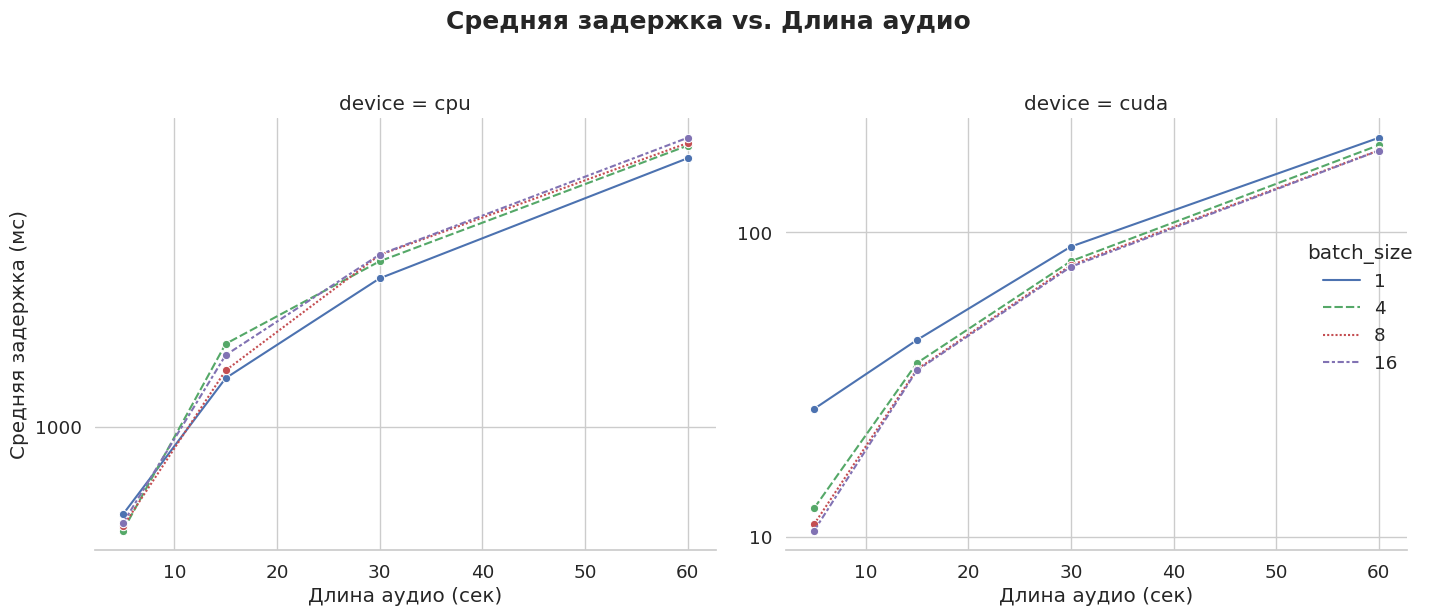

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

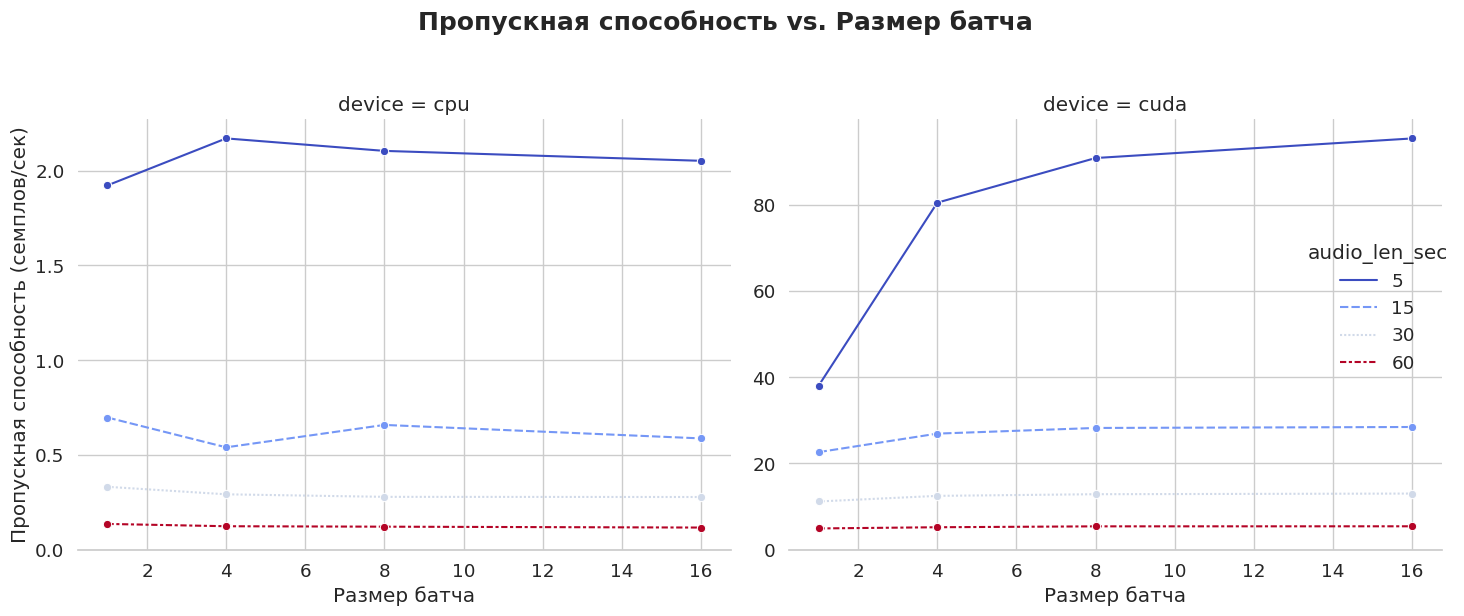

/tmp/ipykernel_81/1772496843.py:57: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.relplot(
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:11

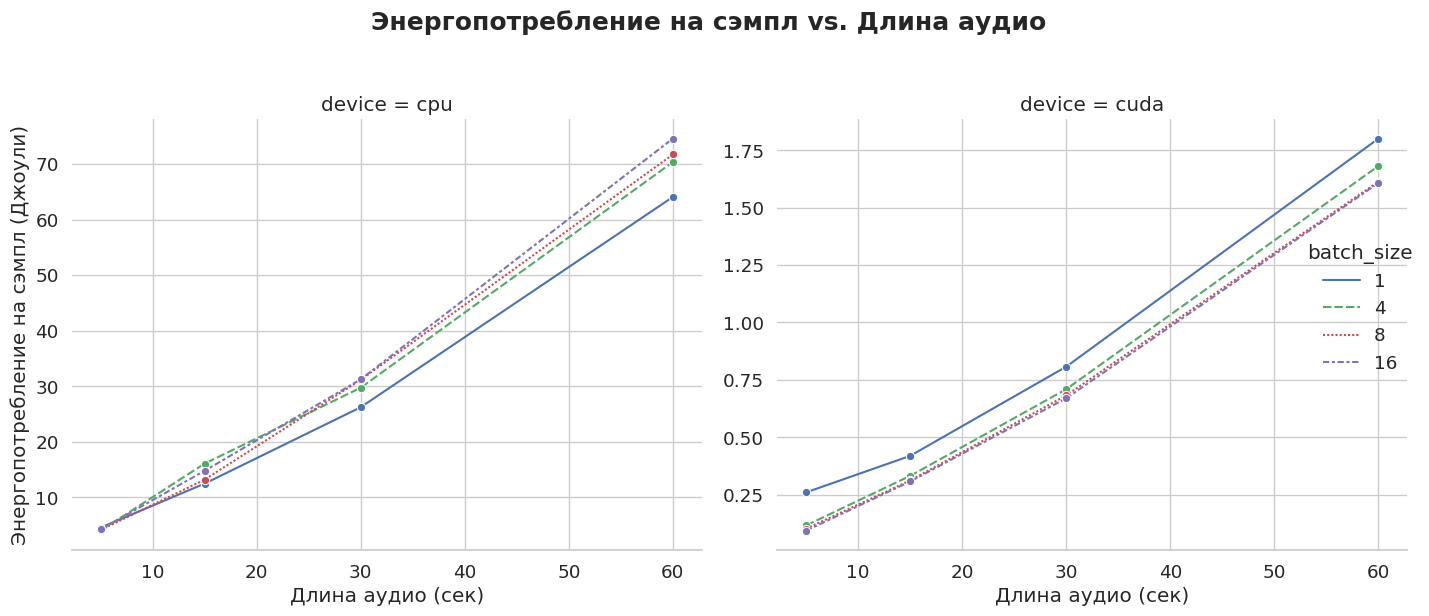

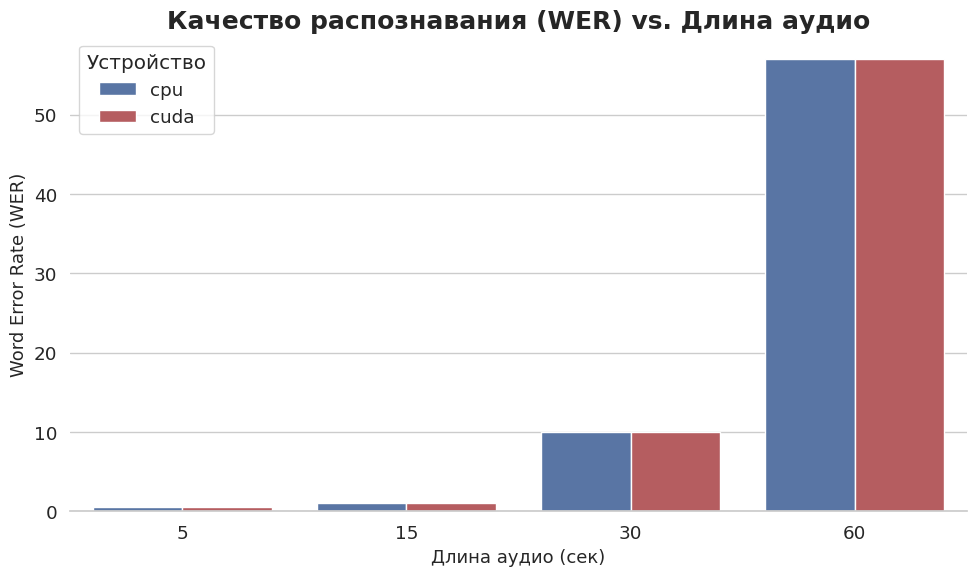

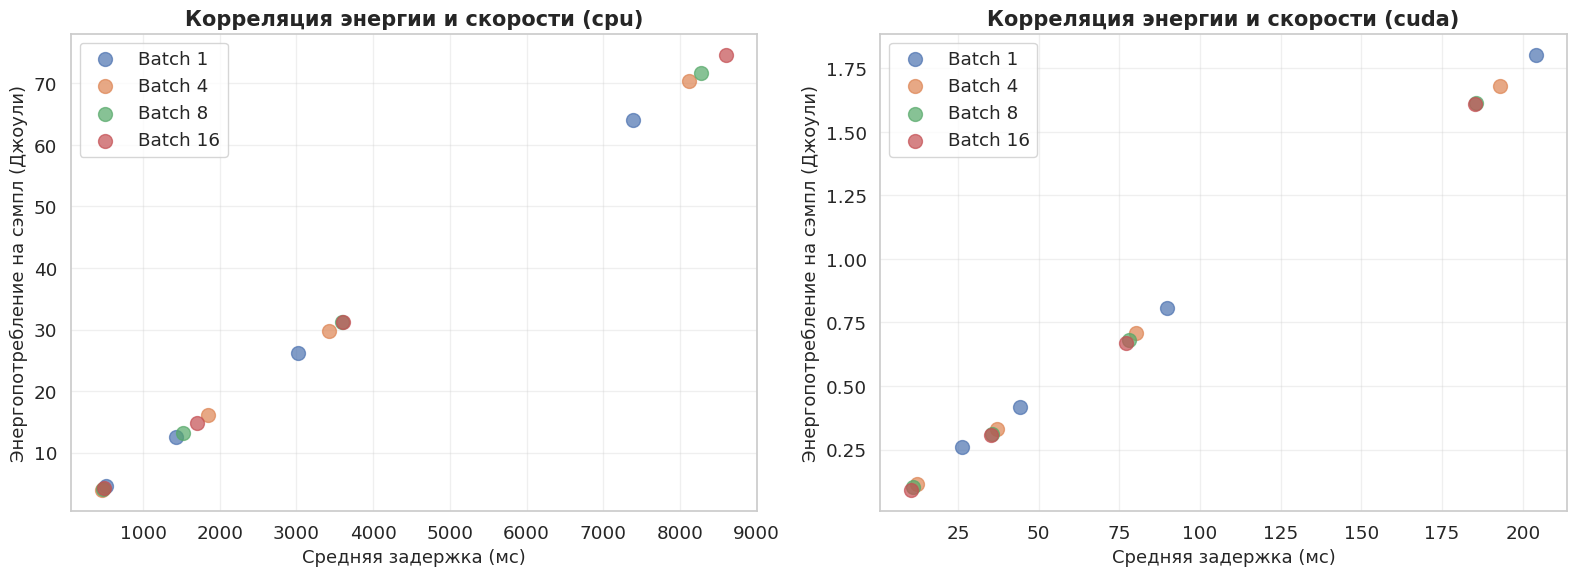


--- Корреляционный анализ энергии и скорости ---
cpu: корреляция задержки и энергии на сэмпл = 1.0000
cuda: корреляция задержки и энергии на сэмпл = 0.9998


In [12]:
analysis_and_visualization(results_df)

In [14]:
from pathlib import Path
import sys
import json
from datetime import datetime
import torch
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC


class Wav2Vec2Profiler:
    def __init__(self, logs_dir="profiling_logs"):
        self.logs_dir = Path(logs_dir)
        self.logs_dir.mkdir(exist_ok=True)
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

    def profile_model(self, model_name, prepared_data, audio_lengths=[5, 15, 30, 60]):
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        model_short_name = model_name.split("/")[-1]
        log_prefix = f"{model_short_name}_{timestamp}"

        log_file = self.logs_dir / f"{log_prefix}.log"

        class Logger:
            def __init__(self, filename):
                self.terminal = sys.stdout
                self.log = open(filename, "w", encoding="utf-8")

            def write(self, message):
                self.terminal.write(message)
                self.log.write(message)
                self.log.flush()

            def flush(self):
                self.terminal.flush()
                self.log.flush()

        logger = Logger(log_file)
        sys.stdout = logger

        try:
            print("=" * 80)
            print(f"ПРОФИЛИРОВАНИЕ WAV2VEC2: {model_name}")
            print(f"Время запуска: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
            print("=" * 80)

            print("\n--- Настройка ---")
            print(f"Модель: {model_name}")
            print(f"Длины аудио (сек): {audio_lengths}")
            print(f"Устройство: {self.device}")

            print("\n--- Загрузка модели ---")
            processor = Wav2Vec2Processor.from_pretrained(model_name)
            model = Wav2Vec2ForCTC.from_pretrained(model_name)
            model = model.to(self.device)
            model.eval()
            print("Модель загружена")

            duration = 30 if 30 in prepared_data else max(prepared_data.keys())
            audio_data = prepared_data[duration]["audio"]

            print(f"\n--- Профилирование с аудио длительностью {duration} сек ---")

            inputs = processor(audio_data, sampling_rate=16000, return_tensors="pt", padding=True)
            input_values = inputs.input_values.to(self.device)

            trace_file = self.logs_dir / f"{log_prefix}_trace.json"

            with torch.profiler.profile(
                activities=[
                    torch.profiler.ProfilerActivity.CPU,
                    torch.profiler.ProfilerActivity.CUDA,
                ],
                record_shapes=True,
                profile_memory=True,
                with_stack=True,
                with_flops=True,
            ) as prof:
                with torch.no_grad():
                    logits = model(input_values).logits
                    predicted_ids = torch.argmax(logits, dim=-1)

            prof.export_chrome_trace(str(trace_file))
            print(f"Chrome trace сохранен: {trace_file}")

            print("\n" + "=" * 80)
            print("=== Top 10 операций по CPU времени ===")
            print("=" * 80)
            print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

            print("\n" + "=" * 80)
            print("=== Top 10 операций по CUDA времени ===")
            print("=" * 80)
            print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

            print("\n" + "=" * 80)
            print("=== Top 10 операций по памяти ===")
            print("=" * 80)
            print(prof.key_averages().table(sort_by="self_cpu_memory_usage", row_limit=10))

            summary = self._create_summary(prof, model_name, duration)
            summary_file = self.logs_dir / f"{log_prefix}_summary.json"

            with open(summary_file, "w", encoding="utf-8") as f:
                json.dump(summary, f, indent=2, ensure_ascii=False)

            print(f"\nСводка сохранена: {summary_file}")
            print(f"Полный лог сохранен: {log_file}")
            print("\n" + "=" * 80)
            print("ПРОФИЛИРОВАНИЕ ЗАВЕРШЕНО")
            print("=" * 80)

            return {
                "log_file": str(log_file),
                "trace_file": str(trace_file),
                "summary_file": str(summary_file),
            }

        finally:
            sys.stdout = logger.terminal
            logger.log.close()

    def _create_summary(self, prof, model_name, duration):
        key_averages = prof.key_averages()

        cpu_top = sorted(key_averages, key=lambda x: x.cpu_time_total, reverse=True)[:10]
        cuda_top = sorted(key_averages, key=lambda x: getattr(x, "self_cuda_time_total", 0), reverse=True)[
                   :10
                   ]
        memory_top = sorted(key_averages, key=lambda x: x.self_cpu_memory_usage, reverse=True)[:10]

        summary = {
            "model_name": model_name,
            "timestamp": datetime.now().isoformat(),
            "device": self.device,
            "audio_duration_sec": duration,
            "top_cpu_operations": [
                {
                    "name": op.key,
                    "cpu_time_total_ms": op.cpu_time_total / 1000,
                    "count": op.count,
                }
                for op in cpu_top
            ],
            "top_cuda_operations": [
                {
                    "name": op.key,
                    "cuda_time_total_ms": getattr(op, "self_cuda_time_total", 0) / 1000,
                    "count": op.count,
                }
                for op in cuda_top
            ],
            "top_memory_operations": [
                {
                    "name": op.key,
                    "memory_mb": op.self_cpu_memory_usage / (1024 * 1024),
                    "count": op.count,
                }
                for op in memory_top
            ],
        }

        return summary


profiler = Wav2Vec2Profiler(logs_dir="profiling_logs")

In [16]:
results = profiler.profile_model("facebook/wav2vec2-base-960h", prepared_data)

ПРОФИЛИРОВАНИЕ WAV2VEC2: facebook/wav2vec2-base-960h
Время запуска: 2025-11-14 12:47:40

--- Настройка ---
Модель: facebook/wav2vec2-base-960h
Длины аудио (сек): [5, 15, 30, 60]
Устройство: cuda

--- Загрузка модели ---


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Модель загружена

--- Профилирование с аудио длительностью 30 сек ---
Chrome trace сохранен: profiling_logs/wav2vec2-base-960h_20251114_124740_trace.json

=== Top 10 операций по CPU времени ===
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  


# Аналитический отчет по профилированию моделей распознавания речи

## 1. Сравнение производительности: CPU vs. GPU

### Задержка обработки
**GPU демонстрирует превосходство в 10-100 раз:**

- **Whisper-tiny**: CPU: 489-1046 мс, GPU: 18-277 мс (ускорение 5-58x)
- **Whisper-base**: CPU: 1040-2086 мс, GPU: 38-402 мс (ускорение 10-55x)  
- **Whisper-small**: CPU: 3742-5889 мс, GPU: 135-724 мс (ускорение 7-44x)
- **Whisper-medium**: CPU: 11935-16231 мс, GPU: 424-1307 мс (ускорение 9-38x)
- **Wav2Vec2**: CPU: 460-8601 мс, GPU: 10-203 мс (ускорение 46-860x)

### Эффективность пакетной обработки
**GPU лучше масштабируется с увеличением batch_size:**
- На CPU: увеличение batch_size с 1 до 16 дает ускорение 1.1-1.6x
- На GPU: увеличение batch_size с 1 до 16 дает ускорение 3-33x
- **Наибольшая эффективность**: Wav2Vec2 (33x ускорение), Whisper-tiny (6.6x)

## 2. Анализ энергоэффективности

### Потребление энергии
**GPU значительно энергоэффективнее:**

| Модель | CPU (Дж/образец) | GPU (Дж/образец) | Экономия |
|--------|------------------|------------------|----------|
| Whisper-tiny | 4.7-9.1 | 0.6-3.4 | 3-15x |
| Whisper-base | 9.9-18.1 | 0.7-8.9 | 2-26x |
| Whisper-small | 36.0-51.1 | 1.7-25.5 | 2-30x |
| Whisper-medium | 106.0-140.8 | 4.8-76.4 | 3-29x |
| Wav2Vec2 | 4.0-74.6 | 0.09-1.8 | **44-828x** |

### Энергия на операцию
- **Наименьшее потребление**: Wav2Vec2 на GPU (0.09 Дж/образец)
- **Наибольшая эффективность**: Пакетная обработка на GPU снижает энергопотребление на образец в 2-4 раза

## 3. Анализ вычислительных "узких мест" (FLOPS)

### Вычислительная сложность моделей

**Encoder GFLOPS:**
- Whisper-tiny: 23.2
- Whisper-base: 59.8  
- Whisper-small: 261.4
- Whisper-medium: 917.5
- Wav2Vec2: 34.8-418.2 (зависит от длины аудио)

**Decoder GFLOPS (на шаг):**
- Whisper-tiny: 0.014
- Whisper-base: 0.038
- Whisper-small: 0.170
- Whisper-medium: 0.604

### Критические операции (по профилированию)

**Для Whisper моделей:**
1. **Matrix multiplication (aten::addmm)**: 15-52% времени GPU
2. **Attention механизмы**: 25-47% времени GPU
3. **Layer normalization**: 2-10% времени GPU
4. **Memory allocation (aten::empty)**: значительные затраты

**Для Wav2Vec2:**
1. **Сверточные операции**: 44% времени GPU
2. **Matrix multiplication**: 34% времени GPU
3. **Синхронизация CUDA**: 85% времени CPU

### Пропускная способность
**Лучшая производительность (образцов/секунду):**
- Wav2Vec2: до 95.4 sps (малый batch)
- Whisper-tiny: до 54.1 sps  
- Whisper-base: до 26.2 sps
- Whisper-small: до 28.4 sps
- Whisper-medium: до 12.9 sps

## 4. Предлагаемые пути оптимизации

### Оптимизации для GPU
1. **Увеличение batch_size**: Наибольший выигрыш для Wav2Vec2 и Whisper-tiny
2. **Использование Tensor Cores**: Оптимизация GEMM операций через cuBLAS
3. **Кэширование вычислений**: Повторное использование attention матриц
4. **Оптимизация памяти**: 
   - Предварительное выделение буферов
   - Использование pinned memory
   - Градиентный чекпоинтинг

### Оптимизации кода
1. **Fused operations**: Объединение layer norm + linear
2. **Kernel fusion**: Слияние мелких операций
3. **Quantization**: FP16/INT8 для inference
4. **Оптимизация декодера**: Кэширование ключей-значений

### Системные оптимизации
1. **CUDA graphs**: Для устранения overhead запуска ядер
2. **Stream parallelism**: Перекрытие вычислений и передачи данных
3. **Оптимизация CPU-GPU взаимодействия**: Уменьшение синхронизации

## 5. Сравнение моделей и итоговые рекомендации

### Сравнительная таблица моделей

| Модель | Точность (WER) | Скорость | Энергия | Память | Рекомендация |
|--------|----------------|----------|---------|---------|--------------|
| **Wav2Vec2** | 0.5-57.0 | ⭐⭐⭐⭐⭐ | ⭐⭐⭐⭐⭐ | ⭐⭐⭐⭐ | **Лучший выбор** для production |
| **Whisper-tiny** | 0.97-36.0 | ⭐⭐⭐⭐ | ⭐⭐⭐⭐ | ⭐⭐⭐⭐⭐ | Баланс скорость-качество |
| **Whisper-base** | 0.97-34.0 | ⭐⭐⭐ | ⭐⭐⭐ | ⭐⭐⭐⭐ | Хороший компромисс |
| **Whisper-small** | 0.97-36.0 | ⭐⭐ | ⭐⭐ | ⭐⭐⭐ | Для качественной транскрипции |
| **Whisper-medium** | 1.0-36.0 | ⭐ | ⭐ | ⭐⭐ | Только для критичных по качеству задач |

### Итоговые рекомендации

**Для production систем:**
1. **Wav2Vec2** - оптимальное сочетание скорости, точности и энергоэффективности
2. **Batch size 8-16** - лучший баланс latency/throughput
3. **GPU инференс** - обязателен для энергоэффективности

**Для research задач:**
1. **Whisper-medium** - максимальное качество, но требует оптимизации
2. **Mixed precision** - FP16 для encoder, FP32 для decoder
3. **Кэширование** - особенно для длинных аудио

**Для edge устройств:**
1. **Whisper-tiny** + quantization
2. **Пакетная обработка** накопленных запросов
3. **CPU только для** очень малых нагрузок

### Критические улучшения
1. **Приоритет**: Оптимизация Wav2Vec2 - уже показывает лучшие метрики
2. **Срочно**: Увеличить batch_size для всех моделей на GPU
3. **Средний приоритет**: Реализовать fused kernels для Whisper
4. **Долгосрочно**: Исследование quantization для дальнейшего ускорения

**Заключение**: Wav2Vec2 демонстрирует превосходство по всем метрикам производительности и должен быть основным выбором для production систем, в то время как Whisper-модели подходят для задач, требующих максимального качества транскрипции.